In [1]:

import calendar

months = list(map(lambda x: x.lower(), calendar.month_name))[1:]
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

import os

project_folder = f'{os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))}/data/process'
import warnings

warnings.filterwarnings(action='ignore')
from IPython.display import display
from IPython.display import Markdown
from IPython.display import display_html




In [22]:
# That's not part of the procedure
pd.read_csv(f'{project_folder}/new_data/new_data.csv').reset_index().iloc[0].to_csv(
    'output_2/fileds_to_work_on.csv')

In [137]:
# show the questions
data_questions = pd.read_csv(f'{project_folder}/new_data/new_data.csv', skiprows=[2]).reset_index().iloc[0]
data_questions


index                                                          0
StartDate                                             Start Date
EndDate                                                 End Date
Status                                             Response Type
IPAddress                                             IP Address
                                     ...                        
Q38            What is the highest level of education you hav...
Q39            What do you consider your main ethnic origin o...
Q39_10_TEXT    What do you consider your main ethnic origin o...
Q40            Where did you hear about this survey? - Select...
Q40_3_TEXT     Where did you hear about this survey? - Other ...
Name: 0, Length: 75, dtype: object

#### Data Preparation

In [61]:
data_general = pd.read_csv(f'{project_folder}/final_geo_coding.csv', skiprows=[1, 2]).reset_index()
# Read dictionary of relevant questions
questions_to_examine = pd.read_csv(f'output_2/fileds_to_work_on_updated.csv')
rel_questions_dic = dict(zip(questions_to_examine['Number'], questions_to_examine['Abbreviation ']))
field_to_work_on = 'index'

In [62]:
special_questions = ['Q26', 'Q27', 'Q32', 'Q33']


In [63]:
questions_to_examine_1 = questions_to_examine.set_index('Number')

In [64]:
res_reg = {}
for question in rel_questions_dic.items():
    question_num = question[0]
    if question_num in special_questions:
        continue
    gb_data = data_general.groupby(question_num).count()[field_to_work_on].rename('count').reset_index()
    sumy = gb_data['count'].sum()
    gb_data['per'] = round(gb_data['count'] / sumy * 100, 0)
    gb_data.sort_values(by='per', ascending=False, inplace=True)

    res_reg[question_num] = gb_data
    # Draw the resuils:
    # gb_data['per'].plot(kind='bar',title=question[1])
    # plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    # plt.show()
res_reg

{'Q25':                                                  Q25  count   per
 2  ​Yes, and I replaced it with exactly what was ...    828  46.0
 0                                                 No    558  31.0
 1     Yes, but the replacement was something cheaper    426  24.0,
 'Q28_1':                     Q28_1  count   per
 1         1-3 days a week    593  34.0
 2   4 or more days a week    518  30.0
 0        1-3 days a month    307  18.0
 5                   Never    154   9.0
 4  Less than once a month    143   8.0
 3     Don't know/not sure     16   1.0,
 'Q28_2':                     Q28_2  count   per
 5                   Never    433  25.0
 1         1-3 days a week    377  22.0
 2   4 or more days a week    358  21.0
 0        1-3 days a month    277  16.0
 4  Less than once a month    239  14.0
 3     Don't know/not sure     16   1.0,
 'Q28_3':                     Q28_3  count   per
 1         1-3 days a week    587  34.0
 2   4 or more days a week    548  32.0
 0        1-3 d

#### Analysis for Q26

In [65]:
data_general['Q26'] = data_general['Q26'].apply(lambda x: str(x).rstrip().lstrip())
gb_data_0 = data_general.groupby('Q26').count()[field_to_work_on].sort_values(ascending=False)
# Values to delete
null_values = ['nan', 'N/a', 'Na', 'na', 'None', '-', 'Months']
gb_data = gb_data_0[~gb_data_0.index.isin(null_values)]

In [66]:
def calc_statistics(class_data: DataFrame):
    r"""
    the class count the number of respondents for the number of days
    :param class_data:
    :return: list of date groupby the number of days, statistics and count and percentage of those with doesn't recover/replace/fix atc. their bicycles
    """
    # remove records without number of days
    num_of_days = class_data['num_of_days']
    final_data = class_data[(num_of_days != '') & (num_of_days != -1)]
    # group by number of days
    mygroupby = final_data.groupby('num_of_days').sum().sort_values(by='count', ascending=False)

    # flat @mygroupby to calculate statistic
    l = [[item[0]] * item[1]['count'] for item in mygroupby.iterrows()]
    flat_list = [item for sublist in l for item in sublist]
    df = DataFrame(flat_list)

    # the number of -1
    no_data = class_data[num_of_days == -1].sum()['count']
    no_dat_dic = (no_data, no_data / (len(flat_list) + no_data) * 100)
    return mygroupby, df.describe(), {'no_action_yet': no_dat_dic}, df


In [67]:
from qu_26_27 import InterpretTime

time_q26 = InterpretTime(gb_data)
for res in time_q26.new_gb_data.iterrows():
    time_q26.main_part(res)
res_26 = calc_statistics(time_q26.new_gb_data)

In [77]:
# merge the interpreted days into our entire dataset and save it into new file
merge_q26 = data_general.copy().set_index('Q26')
merge_q26['num_of_days'] = time_q26.new_gb_data['num_of_days']
# should be fixed later on today
merge_q26.at['4  months','num_of_days'] = 120
merge_q26['num_of_days'] = merge_q26['num_of_days'].replace('', None, regex=True)

# Q26_new stores the class of number of days as define in function below.
def group_num_of_days(val):
    # the class is defined by the number of days store in val
    if val == -1:
        return -1
    if val < 8:
        return 7
    if val < 15:
        return 14
    if val < 31:
        return 30
    if val < 61:
        return 60
    if val < 91:
        return 90
    if val < 181:
        return 180
    if val < 365:
        return 365
    return 730
merge_q26.reset_index(inplace=True)
merge_q26['Q26_new']  = merge_q26['num_of_days'].dropna().apply(group_num_of_days)

merge_q26.to_csv(f'{project_folder}/new_data/new_data_1.csv')

#### Analysis for Q27

In [31]:
gb_data_first = data_general.groupby('Q27').count()[field_to_work_on].sort_values(ascending=False)
gb_data_27 = gb_data_first.dropna()
time_q27 = InterpretTime(gb_data_27)
for res in time_q27.new_gb_data.iterrows():
    time_q27.main_part(res)
res_q27 = calc_statistics(time_q27.new_gb_data)

#### Code for Q32 and Q33 which is multiple choices questions

In [32]:
res32_33 = []
for question_num in special_questions[-2:]:
    print(question_num)
    # Read choice options
    choice_df = pd.read_csv(f'output_2/{question_num}.csv', encoding='cp1252').set_index('question')
    # grpoupby data by the responses to the question_num
    gb_data = data_general.groupby(question_num).count()[field_to_work_on].sort_values(ascending=False).reset_index()
    # Go over each separate response
    for item in choice_df.iterrows():
        question = item[0]
        # search the current response in the multiple choices responses
        for row_0 in gb_data.iterrows():
            row = row_0[1]
            if question in row[question_num]:
                # if the response was found add the number of respondants that use that respomse as part on 1 or combination of choices
                choice_df.loc[question] += row[field_to_work_on]
    # calculate percentage
    sumy = choice_df.sum()
    choice_df['per'] = round(choice_df / sumy * 100, 0)
    choice_df.sort_values(by='per', ascending=False, inplace=True)
    res32_33.append(choice_df)
    # Plot results
    # choice_df['per'].plot(kind='bar',title=rel_questions_dic[question_num])

    # plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    # plt.show()

Q32
Q33


In [33]:
questions_to_examine_1['# Respondents'] = data_general.apply(lambda x: x.count())
html_table = questions_to_examine_1.to_html()
text = "<h4>The following questions will be the main focus of our analysis. We will begin by looking at each question individually.</h4>"
display(Markdown(text))
display_html(html_table, raw=True)

questions_to_examine_1

<h4>The following questions will be the main focus of our analysis. We will begin by looking at each question individually.</h4>

,Question,Abbreviation,# Respondents
Number,,,
Q25,Did you replace the stolen bicycle or bicycle part?,Is replaced,1812
Q26,How many days did it take to recover or replace your stolen bicycle or part?,Time replaced,1821
Q27,"After recovering your bike, how many additional days did it take before your bicycle was repaired and rideable?",Time rideable,33
Q28_1,"Over the past year, how often did you cycle (with any bicycle) during each season? - Fall (Sept, Oct, Nov)",Fall habit,1731
Q28_2,"Over the past year, how often did you cycle (with any bicycle) during each season? - Winter (Dec, Jan, Feb)",Winter habit,1700
Q28_3,"Over the past year, how often did you cycle (with any bicycle) during each season? - Spring (Mar, Apr, May)",Spring habit,1713
Q28_4,"Over the past year, how often did you cycle (with any bicycle) during each season? - Summer (Jun, Jul, Aug)",Summer habit,1710
Q29,"What was the main purpose of the trips you made with the stolen/damaged bicycle? Measured in highest number or trips, not distance cycled",Purpose trip,1728
Q30,"Thinking about the trips you made with the stolen/damaged bicycle, what transportation mode did you most often use to make those trips while your bicycle was unavailable?",Mode switch,1728


,Question,Abbreviation,# Respondents
Number,,,
Q25,Did you replace the stolen bicycle or bicycle ...,Is replaced,1812
Q26,How many days did it take to recover or replac...,Time replaced,1821
Q27,"After recovering your bike, how many additiona...",Time rideable,33
Q28_1,"Over the past year, how often did you cycle (w...",Fall habit,1731
Q28_2,"Over the past year, how often did you cycle (w...",Winter habit,1700
Q28_3,"Over the past year, how often did you cycle (w...",Spring habit,1713
Q28_4,"Over the past year, how often did you cycle (w...",Summer habit,1710
Q29,What was the main purpose of the trips you mad...,Purpose trip,1728
Q30,Thinking about the trips you made with the sto...,Mode switch,1728


In [34]:
q_num = 'Q25'
q = questions_to_examine_1.loc[q_num][0]
res_25 = res_reg[q_num]
more_ex = int(
    res_25[res_25['Q25'] == '\u200bYes, and I replaced it with exactly what was stolen or something more expensive '][
        'per'].values[0])
cheaper = int(res_25[res_25['Q25'] == 'Yes, but the replacement was something cheaper']['per'].values[0])
no = int(res_25[res_25['Q25'] == 'No']['per'].values[0])
text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>{no}% did not replace their stolen bicycle.</li><li> {cheaper}% did replace with cheaper bicycle.</li><li> {more_ex}%  with more expensive bicycle.</li></ul>"
display(Markdown(text))
text = "<h4>Next analysis</h4><ul> <li>cross validation with demographic</li> <li>cross validation with bicycle value</li></ul>"
display(Markdown(text))
res_25

Q25 - Did you replace the stolen bicycle or bicycle part?

<h4>Results</h4><ul><li>31% did not replace their stolen bicycle.</li><li> 24% did replace with cheaper bicycle.</li><li> 46%  with more expensive bicycle.</li></ul>

<h4>Next analysis</h4><ul> <li>cross validation with demographic</li> <li>cross validation with bicycle value</li></ul>

,Q25,count,per
2,"​Yes, and I replaced it with exactly what was ...",828,46.0
0,No,558,31.0
1,"Yes, but the replacement was something cheaper",426,24.0


In [35]:
q_num = 'Q26'
q = questions_to_examine_1.loc[q_num][0]
res = res_26
flat_data = res[-1]
day_25 = int(res[1].loc['25%'][0])
day_50 = int(res[1].loc['50%'][0])
more_365 = len(flat_data[flat_data[0] > 365])
more_385_percentage = int(round(more_365 / len(flat_data) * 100, 0))
max = int(res[1].loc['max'][0])
no_recoverd_replace = int(round(list(res[2].values())[0][1]))
text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>25% recovered or replaced their bicycles within {day_25} days and 50% within {day_50} days.</li>  <li>{more_385_percentage}% are recovered or replaced over 1 year.</li> <li>The longest time  reported to recovered/replaced was {max} days.</li><li>Among all the participants that answers to this question {no_recoverd_replace}% have not recovered/replaces their bicycles.</ul>"
display(Markdown(text))
text = "<h4>Next analysis</h4><ul> <li>compare the results between group members who were replaced and those who recovered. Are there any statistical differences between the two groups? </li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>"
display(Markdown(text))
res[1]


Q26 - How many days did it take to recover or replace your stolen bicycle or part?

<h4>Results</h4><ul><li>25% recovered or replaced their bicycles within 20 days and 50% within 49 days.</li>  <li>4% are recovered or replaced over 1 year.</li> <li>The longest time  reported to recovered/replaced was 1460 days.</li><li>Among all the participants that answers to this question 5% have not recovered/replaces their bicycles.</ul>

<h4>Next analysis</h4><ul> <li>compare the results between group members who were replaced and those who recovered. Are there any statistical differences between the two groups? </li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>

,0
count,1037.000000
mean,98.671167
std,142.170234
min,0.000000
25%,20.000000
50%,49.000000
75%,120.000000
max,1460.000000


In [36]:
q_num = 'Q27'
res = res_q27
q = questions_to_examine_1.loc[q_num][0]
flat_data = res[-1]
day_25 = int(res[1].loc['25%'][0])
day_50 = int(res[1].loc['50%'][0])
more_30 = len(flat_data[flat_data[0] > 30])
more_30_percentage = int(round(more_30 / len(flat_data) * 100, 0))
max = int(res[1].loc['max'][0])
no_recoverd_replace = int(round(list(res[2].values())[0][1]))

text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>25% repaired their bicycles within {day_25} days and 50% within {day_50} days.</li>  <li> {more_30_percentage}% are repaired after more then a month.</li> <li>The longest time  reported to repair was {max} days.</li> <li>Among all the participants that answers to this question {no_recoverd_replace}% have not repaired their bicycles.</li></ul>"
display(Markdown(text))
text = "<h4>Next analysis</h4><ul> <li>cross validation with bike condition upon recovery</li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>"
display(Markdown(text))
res[1]


Q27 - After recovering your bike, how many additional days did it take before your bicycle was repaired and rideable?

<h4>Results</h4><ul><li>25% repaired their bicycles within 7 days and 50% within 14 days.</li>  <li> 28% are repaired after more then a month.</li> <li>The longest time  reported to repair was 360 days.</li> <li>Among all the participants that answers to this question 3% have not repaired their bicycles.</li></ul>

<h4>Next analysis</h4><ul> <li>cross validation with bike condition upon recovery</li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>

,0
count,32.000000
mean,45.281250
std,85.462776
min,0.000000
25%,7.000000
50%,14.000000
75%,42.750000
max,360.000000


In [69]:
frequency = 'frequency'
seasons = {1: 'Fall', 2: 'Winter', 3: 'Spring', 4: 'Summer'}  # list of seasons
data_to_use = [res_reg[f'Q28_{i}'].rename(columns={'per': seasons[i]}) for i in range(1, 5)]
data_to_use_1 = [data.rename(columns={data.columns[0]: frequency}).drop('count', axis=1).set_index(frequency) for data
                 in data_to_use]
seasons_pd = pd.concat(data_to_use_1, axis=1)

frequency_dic = {'4 or more days a week': 5, '1-3 days a week': 4, '1-3 days a month': 3, 'Less than once a month': 2,
                 'Never': 1,
                 "Don't know/not sure": 0}
for_sort = 'for_sort'
seasons_pd[for_sort] = frequency_dic
seasons_pd.sort_values(for_sort).drop(for_sort, axis=1).T

q_num = 'Q28'
q = f"Over the past year, how often did you cycle"
text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>The seasons have huge effect on the cycling habit.</li></ul>"
display(Markdown(text))
text = "<h4>Next analysis</h4><ul> <li>Find group of cyclists with same habit</li> <li>for those groups cross validation with demographic</li><li>with bike characteristics </li><li> with other questions behaviour</li> <li>between cities</li></ul>"
display(Markdown(text))


frequency,Don't know/not sure,Never,Less than once a month,1-3 days a month,1-3 days a week,4 or more days a week
Fall,1.0,9.0,8.0,18.0,34.0,30.0
Winter,1.0,25.0,14.0,16.0,22.0,21.0
Spring,1.0,9.0,6.0,18.0,34.0,32.0
Summer,1.0,7.0,5.0,11.0,35.0,41.0


Q28 - Over the past year, how often did you cycle

<h4>Results</h4><ul><li>The seasons have huge effect on the cycling habit.</li></ul>

<h4>Next analysis</h4><ul> <li>Find group of cyclists with same habit</li> <li>for those groups cross validation with demographic</li><li>with bike characteristics </li><li> with other questions behaviour</li> <li>between cities</li></ul>

In [124]:
qu_seasons ={'Q28_1': 'Fall', 'Q28_2': 'Winter', 'Q28_3': 'Spring', 'Q28_4': 'Summer'}
my_reindex = list(frequency_dic.keys())
data_general.rename(columns=qu_seasons, inplace=True)
pd.crosstab(index=data_general['Fall'], columns=data_general['Winter'], normalize='columns').reindex(columns=my_reindex,
                                                                                                     index=my_reindex) * 100




Winter,1-3 days a month,1-3 days a week,4 or more days a week,Don't know/not sure,Less than once a month,Never,All
Fall,,,,,,,
1-3 days a month,107,5,1,0,74,113,300
1-3 days a week,141,279,4,2,74,81,581
4 or more days a week,22,87,352,2,15,32,510
Don't know/not sure,0,1,0,12,0,2,15
Less than once a month,4,1,0,0,72,66,143
Never,3,3,1,0,4,139,150
All,277,376,358,16,239,433,1699


# Ridership profile code


          Fall_en   Winter_en   Spring_en   Summer_en    Q28
count  799.000000  799.000000  799.000000  799.000000  799.0
mean     4.453066    4.351690    4.454318    4.421777    0.0
std      0.662257    0.643237    0.725548    0.821745    0.0
min      3.000000    3.000000    1.000000    0.000000    0.0
25%      4.000000    4.000000    4.000000    4.000000    0.0
50%      5.000000    4.000000    5.000000    5.000000    0.0
75%      5.000000    5.000000    5.000000    5.000000    0.0
max      5.000000    5.000000    5.000000    5.000000    0.0
          Fall_en   Winter_en   Spring_en   Summer_en    Q28
count  226.000000  226.000000  226.000000  226.000000  226.0
mean     1.438053    1.238938    1.451327    1.424779    1.0
std      0.782113    0.607718    0.810938    0.751949    0.0
min      0.000000    0.000000    0.000000    0.000000    1.0
25%      1.000000    1.000000    1.000000    1.000000    1.0
50%      1.000000    1.000000    1.000000    1.000000    1.0
75%      2.000000    1.0

<AxesSubplot: >

<AxesSubplot: xlabel='seasons', ylabel=' Ridership Frequency'>

<AxesSubplot: xlabel='seasons', ylabel=' Ridership Frequency'>

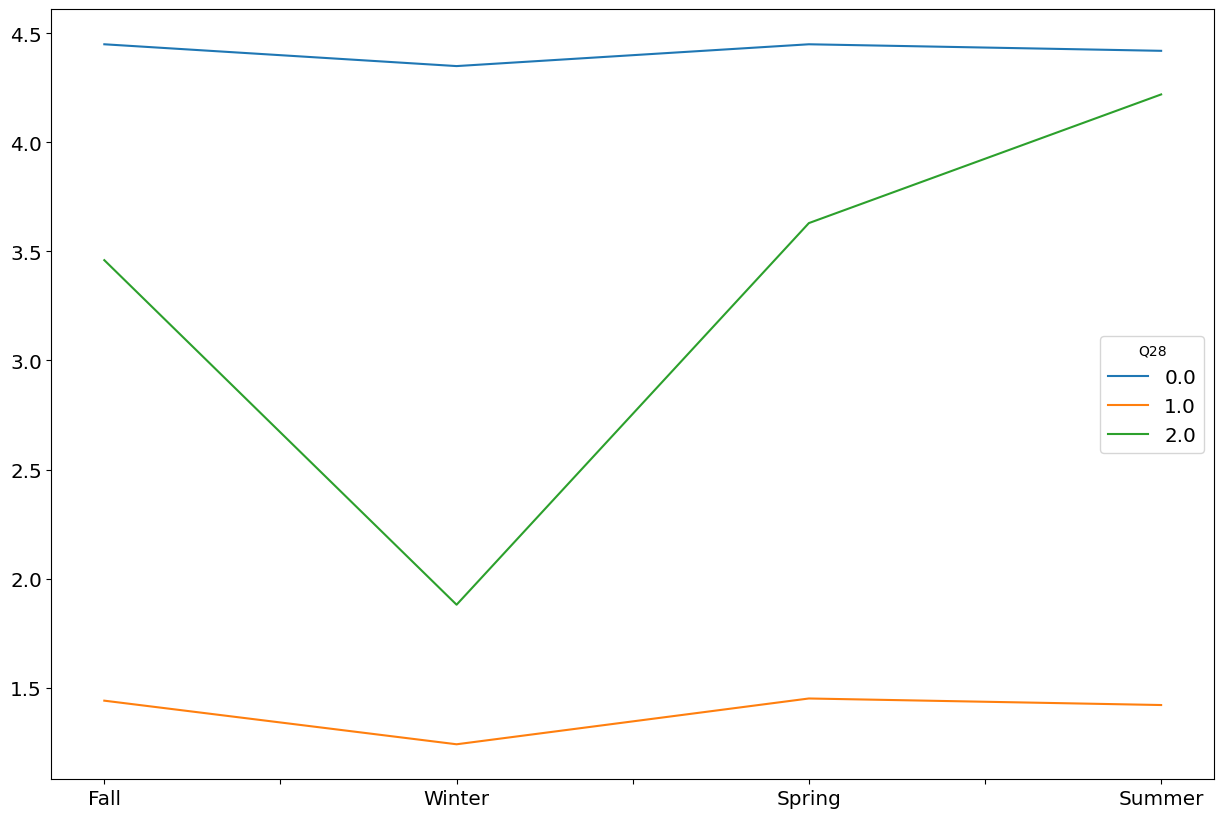

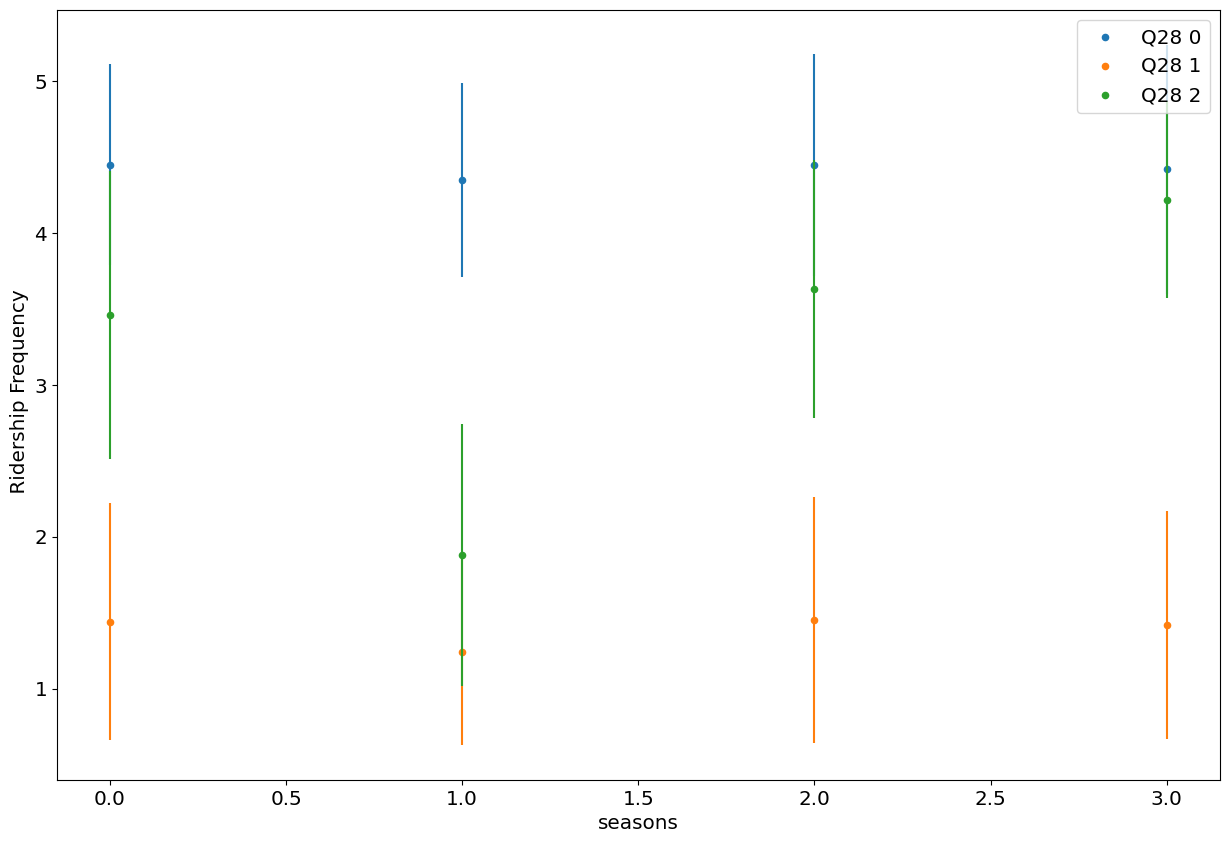

In [71]:

from sklearn.cluster import AgglomerativeClustering

# Parameters for this
n = 3
my_class = 'Q28'
seasons_values = list(seasons.values())
color_list = [color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'][:n]]


# get all the relevant code into new dataframe (remove rows with Null values)
data_general_classification = data_general.copy()[list(seasons_values)+['index']].dropna().rename(columns={'index':'old_index'})


# Encoding
new_cols = [f'{d}_en' for d in seasons_values]
data_general_classification[new_cols] = data_general_classification[seasons_values].apply(lambda row: [frequency_dic[y] for y in row],
                                                                          axis=1, result_type='expand')


# Classification using AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=n)
clas_res = cluster.fit_predict(data_general_classification[new_cols].to_numpy())

# --- for test only---
# import collections
# counts = collections.Counter(clas_res)
# --- for test only---

data_general_classification[my_class] = clas_res

# for analysis
sum_data = []
std_data = []
data_to_analysis = data_general_classification.drop(columns=seasons_values+['old_index'])

# visualization
for x in range(n):
    class_data = data_to_analysis[data_to_analysis[my_class] == x]
    # show the mean for each group and for each season
    class_data_describe = class_data.describe()
    print(class_data_describe)
    sum_data.append(list(round(class_data_describe.loc['mean'], 2).values))
    std_data.append(list(round(class_data_describe.loc['std'], 2).values))

# mean
# sum_data
# std_data
DataFrame(data=sum_data, columns=list(seasons.values()) + [my_class]).set_index(my_class).T.plot(color=color_list)

# mean + std
mean_df = DataFrame(data=sum_data, columns=list(seasons.values()) + [my_class]).set_index(my_class).T
std_df = DataFrame(data=std_data, columns=list(seasons.values()) + [my_class]).set_index(my_class).T
std_df.columns = range(n)

for i in range(n):
    data_prep = mean_df[i].reset_index(drop=True).reset_index().rename(columns={'index': 'x', i: 'y'})
    if i == 0:
        ax = data_prep.plot(kind='scatter', x='x', y='y', color=color_list[i],
                            yerr=std_df[i].reset_index(drop=True).reset_index()[i], label=f'{my_class} {i}',
                            xlabel='Seasons', ylabel=' Ridership Frequency')
    else:
        data_prep.plot(kind='scatter', x='x', y='y', color=color_list[i],
                       yerr=std_df[i].reset_index(drop=True).reset_index()[i], ax=ax, label=f'{my_class} {i}',
                       xlabel='seasons', ylabel=' Ridership Frequency')
plt.legend()
plt.show()

In [83]:
# merge the results into our database and save it into a new file
merge_q = merge_q26.set_index('index')
merge_q[my_class] =data_general_classification.set_index('old_index')[my_class]
# calculate decades for age
merge_q['Q34_1'] = merge_q['Q34'].dropna().map(lambda x:str(int(x/10)*10) +'s')
merge_q.to_csv(f'{project_folder}/new_data/new_data_2.csv')

In [73]:
q_num = 'Q29'
res_reg[q_num]
q = questions_to_examine_1.loc[q_num][0]

,Q29,count,per
2,"Recreation or exercise (e.g., cycling in your ...",721,42.0
3,"Transportation (e.g., commuting to school or w...",542,31.0
1,"Equal mix of recreation, exercise, and transpo...",455,26.0
0,Don’t know/not sure,10,1.0


In [31]:
q_num = 'Q30'
res_reg[q_num]
q = questions_to_examine_1.loc[q_num][0]
q

,Q30,count,per
0,"Car, as a driver (e.g., personal vehicle, cars...",611,35.0
2,"Cycle, personal bicycle (e.g., own a second bi...",291,17.0
11,Walk,282,16.0
5,Didn’t make those trips,221,13.0
10,"Transit (e.g., bus/rail)",163,9.0
1,"Car, as a passenger (e.g., given rides by frie...",57,3.0
3,"Cycle, public bike share",27,2.0
6,Don’t know/not sure,29,2.0
4,"Cycle, rental bicycle",11,1.0
7,"Micro mobility (e.g., e-scooter, e-unicycle, e...",9,1.0


'Thinking about the trips you made with the stolen/damaged bicycle, what transportation mode did you most often use to make those trips while your bicycle was unavailable?'

In [9]:
q_num = 'Q31'
res_reg[q_num]
q = questions_to_examine_1.loc[q_num][0]
q

,Q31,count,per
0,About the same / no change,852,49.0
2,Less often,511,30.0
1,I stopped cycling,263,15.0
3,More often,104,6.0


'Compared to before the theft, what best describes your overall cycling activity after your stolen bicycle (or part) was recovered, replaced, or abandoned? Did you cycle…'

In [32]:
q_num = 'Q32'
q = questions_to_examine_1.loc[q_num][0]
most_pop = res32_33[0].iloc[0]
text = f"{q_num} - {q}"
display(Markdown(text))
text = f"<h4>Results</h4><ul><li>the answer with the highest  frequency is:</li></ul>"
display(Markdown(text))
most_pop
q_num = 'Q33'
q = questions_to_examine_1.loc[q_num][0]
most_pop = res32_33[1].iloc[0]
text = f"{q_num} - {q}"
display(Markdown(text))
len_all = len(data_general)
percentage_of_ans = int(round((len_all - data_general[q_num].isna().sum()) / len_all * 100))
text = f"<h4>Results</h4><ul><li>only {percentage_of_ans}% answer this question.</li><li>the answer with the highest  frequency is :</li></ul>"
display(Markdown(text))
most_pop

text = "<h4>Next analysis</h4><ul> <li>group choices</li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>"
display(Markdown(text))
res32_33[0]
res32_33[1]

Q32 - What were the main reasons you cycled less often or not at all? (Select up to 3) - Selected Choice

<h4>Results</h4><ul><li>the answer with the highest  frequency is:</li></ul>

count    307.0
per       25.0
Name: I couldn’t recover my bicycle and didn’t replace it due to cost or other reason, dtype: float64

Q33 - What were the main reasons you cycled more often? (Select up to 3) - Selected Choice

<h4>Results</h4><ul><li>only 6% answer this question.</li><li>the answer with the highest  frequency is :</li></ul>

count    49.0
per      26.0
Name: My new bicycle was more capable, comfortable to ride, or better suited to my travel needs, dtype: float64

<h4>Next analysis</h4><ul> <li>group choices</li> <li>cross validation with demographic</li><li>cross validation with bike characteristics</li></ul>

,count,per
question,,
I couldn’t recover my bicycle and didn’t replace it due to cost or other reason,307,25.0
There might not be a safe place to park my bicycle at the places I go,216,18.0
Became accustomed to travelling with a different mode,118,10.0
Other (please specify):,125,10.0
My new bicycle isn’t as capable or comfortable to ride,113,9.0
I don’t have a safe place to store my bicycle at home,94,8.0
"High-security locks or secure parking locations involve a great deal of effort, inconvenience, or difficulty to access my bicycle",89,7.0
"My cycling equipment/accessories/gear (e.g., panniers, lock, lights, rack, basket) necessary to make my usual cycling trips were stolen or damaged",75,6.0
Not riding has made me too out of shape to make my usual cycling trips,47,4.0


,count,per
question,,
"My new bicycle was more capable, comfortable to ride, or better suited to my travel needs",49,26.0
Reasons unrelated to the theft,34,18.0
"I was motivated to purchase new cycling equipment/accessories/gear (e.g., panniers, lock, lights, rack, basket, cycle computer, rain gear) to make more frequent cycling trips, have more enjoyable trips, or visit new places",27,14.0
"Upgraded the quality of lock I use and/or used another type of anti-theft device, so I was less worried about theft",24,13.0
Other (please specify):,25,13.0
"I added my bicycle to a registry/recovery system, so I was less worried about theft",11,6.0
I replaced my stolen bicycle with an e-bike,6,3.0
"My replacement bicycle was used or less expensive than the stolen bike, so I was less worried about theft",6,3.0
"My recovered bicycle was cosmetically damaged, or I made it look unattractive, so I was less worried about theft",3,2.0


In [13]:
text = f"<h4>Research Questions</h4><ul><li>The change in behavior following theft (Q25 - Q27 and Q30- Q33). These questions should be cross tabulated with demographic, bike type and Q28 different  personal profile type and Q29</li></ul>"
display(Markdown(text))

<h4>Research Questions</h4><ul><li>The change in behavior following theft (Q25 - Q27 and Q30- Q33). These questions should be cross tabulated with demographic, bike type and Q28different  personal profile type and Q29</li></ul>

In [ ]:
# list with question number
# add Q
questions = [f'Q{num}' for num in list(range(25, 28)) + list(range(30, 34))]
# get the tables from the dic
res_25
res_26
res_q27
# present them


### Cross Tabulation

#### General

In [162]:
merge_q = pd.read_csv(f'{project_folder}/new_data/new_data_2.csv')

In [163]:
questions_to_analysis = ['Q2','Q10','Q12','Q13','Q14','Q15','Q18','Q24','Q25', 'Q26_new', 'Q28', 'Q29', 'Q30', 'Q31','Q34_1','Q35','Q36','Q37','Q38','Q39','country','city']
special_reindex= ['Q13','Q15','Q30','Q31','Q36','Q37','Q38','Q39','city']

# reindex general
reindex_dic={val:DataFrame(merge_q[val].unique()).dropna().sort_values(by=0,ascending=1)[0].to_list() for val in questions_to_analysis if val not in special_reindex}

# reindex the options in q13
q13= 'Q13'
df = DataFrame(merge_q[q13].unique()).dropna().sort_values(by=0,ascending=0).reset_index(drop=True)
reindex_dic[q13] = pd.concat([df.iloc[0], df.iloc[6], df.iloc[4],df.iloc[8],df.iloc[7],df.iloc[5],df.iloc[1:4].sort_values(by=0,ascending=1)])[0].to_list()

# reindex the options in q15 - by frequency
q15= 'Q15'
reindex_dic[q15] = merge_q.groupby(q15).count().sort_values(by='index',ascending=False).index.to_list()

# reindex the options in q30
q30= 'Q30'
df= DataFrame(merge_q[q30].unique()).dropna().sort_values(by=0,ascending=1).reset_index(drop=True)
reindex_dic[q30]= pd.concat([df.iloc[:2], df.iloc[9:11], df.iloc[7:9],df.iloc[2:5],df.iloc[-1],df.iloc[5:7]])[0].to_list()

# reindex the options in q39 - by the
q31= 'Q31'
df= DataFrame(merge_q[q31].unique()).dropna().sort_values(by=0,ascending=1)
reindex_dic[q31] = pd.concat([df.iloc[1:3], df.iloc[0], df.iloc[-1]])[0].to_list()

# reindex the options in q36
q36 = 'Q36'
df= DataFrame(merge_q[q36].unique()).dropna().sort_values(by=0,ascending=0)
temp_2 = df.iloc[3:7].sort_values(by=0,ascending=1)
temp_3 = df.iloc[7:9].sort_values(by=0,ascending=1)
reindex_dic[q36] = pd.concat([df.iloc[0],temp_2,temp_3,df.iloc[-1],df.iloc[1:3]])[0].to_list()


# reindex the options in q37
numbers = {
    "zero":0,
     "one": 1,
     "two": 2,
     "three": 3,
     "four":4,
    "five":5
 }
def def_reindex_q37(a):
    reindex_q37[numbers.get(a.split()[0].lower(),6)] = a

q37= 'Q37'
reindex_q37 = [0 for b in range(7)]
df= DataFrame(merge_q[q37].unique()).dropna().sort_values(by=0,ascending=0)
_ = df[0].apply(def_reindex_q37)
reindex_dic[q37] =reindex_q37

# reindex the options in q38
q38= 'Q38'
df= DataFrame(merge_q[q38].unique()).dropna().sort_values(by=0,ascending=1)
reindex_dic[q38] = pd.concat([df.iloc[-2], df.iloc[3], df.iloc[-1],df.iloc[:3],df.iloc[4]])[0].to_list()

# reindex the options in q39 - by frequency
q39= 'Q39'
reindex_dic[q39]= merge_q.groupby(q39).count().sort_values(by='index',ascending=False).index.to_list()




In [158]:
def my_cross_tab(array_main,array_sec,local_db):
    r"""
    cross tabulation between all the questions in array_main and the questions in array_sec in local_db
    :param local_db:
    :param array_main:
    :param array_sec:
    :return:
    """
    data_list=[]
    for val in array_main:
        re_index_row = reindex_dic[val]
        for val_2 in array_sec:
                re_index_col = reindex_dic[val_2]
                data_list.append(round(pd.crosstab(index=local_db[val], columns=local_db[val_2], normalize='columns'),2).reindex(columns=re_index_col,index= re_index_row) * 100)
                data_list.append(pd.crosstab(index=local_db[val], columns=local_db[val_2]).reindex(columns=re_index_col,index= re_index_row))
    return data_list

#### With Demographic questions

In [134]:
habit_q = ['Q25', 'Q26_new', 'Q28', 'Q29', 'Q30', 'Q31']
demographic = ['Q34_1','Q35','Q36','Q37','Q38','Q39']
data_list = my_cross_tab( habit_q,demographic,merge_q)
for data_res in data_list:
    data_res

Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q25,,,,,,,,,
No,0.0,30.0,26.0,24.0,27.0,32.0,36.0,34.0,0.0
"Yes, but the replacement was something cheaper",0.0,11.0,20.0,21.0,25.0,21.0,28.0,34.0,0.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",100.0,59.0,54.0,55.0,48.0,48.0,36.0,32.0,100.0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q25,,,,,,,,,
No,0,8,32,47,89,161,143,27,0
"Yes, but the replacement was something cheaper",0,3,24,42,82,107,110,27,0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",2,16,65,108,156,243,144,25,5


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q25,,,,
No,30.0,24.0,46.0,31.0
"Yes, but the replacement was something cheaper",22.0,43.0,29.0,25.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",48.0,33.0,26.0,44.0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q25,,,,
No,311,5,16,190
"Yes, but the replacement was something cheaper",233,9,10,153
"​Yes, and I replaced it with exactly what was stolen or something more expensive",502,7,9,266


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q25,,,,,,,,,,
No,35.0,36.0,37.0,33.0,32.0,32.0,28.0,23.0,31.0,41.0
"Yes, but the replacement was something cheaper",45.0,35.0,24.0,28.0,20.0,20.0,21.0,20.0,20.0,35.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",20.0,28.0,39.0,39.0,47.0,48.0,51.0,57.0,49.0,24.0


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q25,,,,,,,,,,
No,29,40,34,72,75,86,48,81,49,7
"Yes, but the replacement was something cheaper",37,39,22,61,47,54,37,71,31,6
"​Yes, and I replaced it with exactly what was stolen or something more expensive",17,31,36,85,109,128,89,205,78,4


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q25,,,,,,,
No,93.0,23.0,20.0,23.0,20.0,20.0,45.0
"Yes, but the replacement was something cheaper",4.0,29.0,27.0,27.0,20.0,19.0,0.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",3.0,48.0,53.0,50.0,59.0,60.0,55.0


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q25,,,,,,,
No,196,145,82,46,22,28,5
"Yes, but the replacement was something cheaper",8,188,108,53,22,27,0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",7,309,214,100,64,84,6


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q25,,,,,,,
No,31.0,40.0,40.0,37.0,34.0,24.0,24.0
"Yes, but the replacement was something cheaper",47.0,26.0,25.0,19.0,23.0,24.0,12.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",22.0,34.0,35.0,44.0,43.0,52.0,64.0


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q25,,,,,,,
No,10,21,49,41,222,173,6
"Yes, but the replacement was something cheaper",15,14,30,21,155,168,3
"​Yes, and I replaced it with exactly what was stolen or something more expensive",7,18,42,48,285,368,16


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q25,,,,,,,,,,,,
No,29.0,37.0,30.0,31.0,40.0,31.0,35.0,37.0,38.0,45.0,75.0,0.0
"Yes, but the replacement was something cheaper",24.0,24.0,22.0,20.0,19.0,25.0,23.0,16.0,19.0,27.0,0.0,75.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",47.0,39.0,48.0,49.0,40.0,43.0,42.0,47.0,44.0,27.0,25.0,25.0


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q25,,,,,,,,,,,,
No,367,36,25,23,21,16,11,7,6,5,3,0
"Yes, but the replacement was something cheaper",303,24,18,15,10,13,7,3,3,3,0,3
"​Yes, and I replaced it with exactly what was stolen or something more expensive",588,38,39,37,21,22,13,9,7,3,1,1


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q26_new,,,,,,,,,
-1.0,0.0,0.0,5.0,7.0,4.0,4.0,5.0,2.0,0.0
7.0,0.0,6.0,8.0,10.0,11.0,12.0,13.0,32.0,20.0
14.0,0.0,0.0,11.0,7.0,8.0,10.0,11.0,10.0,20.0
30.0,50.0,56.0,25.0,22.0,18.0,22.0,20.0,29.0,60.0
60.0,0.0,12.0,19.0,22.0,19.0,14.0,18.0,15.0,0.0
90.0,0.0,0.0,7.0,5.0,10.0,13.0,7.0,7.0,0.0
180.0,50.0,12.0,8.0,13.0,15.0,14.0,14.0,0.0,0.0
365.0,0.0,0.0,8.0,5.0,6.0,6.0,6.0,0.0,0.0
730.0,0.0,12.0,8.0,8.0,8.0,5.0,7.0,5.0,0.0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q26_new,,,,,,,,,
-1.0,0,0,4,9,9,11,11,1,0
7.0,0,1,7,13,23,38,28,13,1
14.0,0,0,9,9,18,31,23,4,1
30.0,1,9,21,29,39,68,43,12,3
60.0,0,2,16,29,41,43,38,6,0
90.0,0,0,6,6,21,39,15,3,0
180.0,1,2,7,17,32,42,30,0,0
365.0,0,0,7,7,12,17,14,0,0
730.0,0,2,7,10,17,16,15,2,0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q26_new,,,,
-1.0,3.0,6.0,12.0,6.0
7.0,13.0,6.0,12.0,11.0
14.0,9.0,12.0,6.0,9.0
30.0,24.0,25.0,12.0,19.0
60.0,18.0,12.0,12.0,16.0
90.0,8.0,0.0,12.0,10.0
180.0,11.0,25.0,12.0,15.0
365.0,6.0,6.0,0.0,6.0
730.0,7.0,6.0,24.0,7.0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q26_new,,,,
-1.0,22,1,2,21
7.0,81,1,2,41
14.0,60,2,1,33
30.0,156,4,2,71
60.0,115,2,2,60
90.0,53,0,2,36
180.0,72,4,2,56
365.0,38,1,0,22
730.0,43,1,4,25


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q26_new,,,,,,,,,,
-1.0,4.0,7.0,6.0,4.0,2.0,4.0,8.0,4.0,5.0,0.0
7.0,20.0,16.0,8.0,9.0,12.0,13.0,11.0,14.0,4.0,50.0
14.0,10.0,7.0,8.0,14.0,7.0,11.0,5.0,8.0,13.0,0.0
30.0,16.0,23.0,20.0,22.0,20.0,23.0,24.0,25.0,18.0,50.0
60.0,16.0,11.0,10.0,18.0,23.0,18.0,14.0,18.0,19.0,0.0
90.0,6.0,3.0,10.0,8.0,7.0,9.0,14.0,9.0,11.0,0.0
180.0,16.0,16.0,16.0,9.0,11.0,15.0,12.0,13.0,13.0,0.0
365.0,4.0,7.0,12.0,8.0,7.0,6.0,6.0,3.0,5.0,0.0
730.0,8.0,10.0,10.0,7.0,10.0,2.0,6.0,5.0,13.0,0.0


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q26_new,,,,,,,,,,
-1.0,2,4,3,5,3,6,9,9,5,0
7.0,10,10,4,11,16,21,12,33,4,4
14.0,5,4,4,18,10,18,6,19,12,0
30.0,8,14,10,28,27,37,27,60,17,4
60.0,8,7,5,23,31,30,15,42,18,0
90.0,3,2,5,10,10,14,15,22,10,0
180.0,8,10,8,11,15,25,13,32,12,0
365.0,2,4,6,10,10,9,7,8,5,0
730.0,4,6,5,9,14,3,7,13,12,0


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q26_new,,,,,,,
-1.0,29.0,3.0,3.0,7.0,10.0,5.0,0.0
7.0,14.0,13.0,9.0,11.0,16.0,13.0,0.0
14.0,21.0,9.0,8.0,15.0,9.0,5.0,0.0
30.0,14.0,23.0,26.0,22.0,14.0,20.0,25.0
60.0,0.0,16.0,20.0,16.0,21.0,16.0,0.0
90.0,7.0,9.0,9.0,8.0,8.0,11.0,0.0
180.0,7.0,12.0,14.0,12.0,11.0,16.0,25.0
365.0,0.0,7.0,5.0,4.0,5.0,8.0,25.0
730.0,7.0,8.0,7.0,5.0,6.0,5.0,25.0


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q26_new,,,,,,,
-1.0,4,12,8,9,8,5,0
7.0,2,57,26,15,13,12,0
14.0,3,40,22,20,7,5,0
30.0,2,98,74,29,11,18,1
60.0,0,70,56,21,17,15,0
90.0,1,37,26,11,6,10,0
180.0,1,53,39,16,9,15,1
365.0,0,29,14,6,4,7,1
730.0,1,33,21,7,5,5,1


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q26_new,,,,,,,
-1.0,6.0,3.0,6.0,9.0,4.0,4.0,12.0
7.0,17.0,10.0,16.0,7.0,13.0,11.0,19.0
14.0,22.0,3.0,6.0,9.0,10.0,9.0,12.0
30.0,17.0,31.0,29.0,21.0,18.0,24.0,31.0
60.0,0.0,17.0,15.0,19.0,18.0,18.0,0.0
90.0,11.0,14.0,10.0,5.0,8.0,9.0,6.0
180.0,11.0,10.0,11.0,10.0,14.0,13.0,12.0
365.0,6.0,3.0,2.0,10.0,6.0,6.0,0.0
730.0,11.0,7.0,5.0,10.0,9.0,6.0,6.0


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q26_new,,,,,,,
-1.0,1,1,4,5,14,19,2
7.0,3,3,10,4,52,50,3
14.0,4,1,4,5,38,43,2
30.0,3,9,18,12,71,115,5
60.0,0,5,9,11,68,86,0
90.0,2,4,6,3,31,44,1
180.0,2,3,7,6,55,59,2
365.0,1,1,1,6,24,28,0
730.0,2,2,3,6,33,26,1


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q26_new,,,,,,,,,,,,
-1.0,5.0,0.0,2.0,4.0,7.0,3.0,6.0,0.0,0.0,33.0,0.0,0.0
7.0,12.0,16.0,12.0,13.0,11.0,7.0,19.0,9.0,11.0,0.0,0.0,0.0
14.0,9.0,14.0,12.0,16.0,0.0,10.0,0.0,9.0,0.0,0.0,0.0,0.0
30.0,23.0,20.0,26.0,11.0,30.0,30.0,19.0,18.0,11.0,17.0,0.0,0.0
60.0,18.0,16.0,12.0,18.0,4.0,30.0,12.0,18.0,33.0,0.0,0.0,0.0
90.0,9.0,8.0,8.0,11.0,7.0,7.0,6.0,9.0,11.0,0.0,0.0,0.0
180.0,12.0,16.0,18.0,11.0,19.0,10.0,12.0,9.0,0.0,0.0,100.0,75.0
365.0,6.0,2.0,2.0,4.0,4.0,0.0,6.0,9.0,11.0,17.0,0.0,25.0
730.0,6.0,10.0,8.0,11.0,19.0,3.0,19.0,18.0,22.0,33.0,0.0,0.0


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q26_new,,,,,,,,,,,,
-1.0,37,0,1,2,2,1,1,0,0,2,0,0
7.0,94,8,6,6,3,2,3,1,1,0,0,0
14.0,72,7,6,7,0,3,0,1,0,0,0,0
30.0,180,10,13,5,8,9,3,2,1,1,0,0
60.0,139,8,6,8,1,9,2,2,3,0,0,0
90.0,71,4,4,5,2,2,1,1,1,0,0,0
180.0,96,8,9,5,5,3,2,1,0,0,1,3
365.0,50,1,1,2,1,0,1,1,1,1,0,1
730.0,44,5,4,5,5,1,3,2,2,2,0,0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q28,,,,,,,,,
0.0,50.0,38.0,51.0,51.0,51.0,47.0,43.0,58.0,20.0
1.0,0.0,21.0,9.0,7.0,10.0,15.0,17.0,15.0,0.0
2.0,50.0,42.0,40.0,42.0,39.0,38.0,40.0,27.0,80.0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q28,,,,,,,,,
0.0,1,9,59,96,163,234,167,43,1
1.0,0,5,10,14,33,74,66,11,0
2.0,1,10,46,80,123,192,157,20,4


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q28,,,,
0.0,53.0,68.0,46.0,38.0
1.0,11.0,0.0,26.0,17.0
2.0,37.0,32.0,29.0,45.0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q28,,,,
0.0,535,13,16,225
1.0,108,0,9,101
2.0,375,6,10,265


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q28,,,,,,,,,,
0.0,53.0,42.0,41.0,39.0,42.0,47.0,59.0,54.0,44.0,62.0
1.0,18.0,19.0,20.0,14.0,14.0,12.0,7.0,12.0,12.0,19.0
2.0,29.0,40.0,40.0,47.0,44.0,41.0,34.0,34.0,44.0,19.0


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q28,,,,,,,,,,
0.0,42,45,37,84,94,122,98,188,69,10
1.0,14,20,18,30,31,32,12,40,19,3
2.0,23,43,36,101,98,106,56,118,69,3


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q28,,,,,,,
0.0,21.0,43.0,50.0,59.0,65.0,68.0,64.0
1.0,48.0,15.0,5.0,2.0,6.0,1.0,18.0
2.0,32.0,43.0,45.0,39.0,29.0,31.0,18.0


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q28,,,,,,,
0.0,42,267,196,116,69,93,7
1.0,97,91,20,3,6,1,2
2.0,64,266,174,77,31,42,2


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q28,,,,,,,
0.0,53.0,51.0,48.0,29.0,45.0,52.0,46.0
1.0,17.0,10.0,13.0,16.0,15.0,11.0,19.0
2.0,30.0,39.0,39.0,55.0,40.0,37.0,35.0


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q28,,,,,,,
0.0,16,26,55,31,291,357,12
1.0,5,5,15,17,96,77,5
2.0,9,20,44,58,263,253,9


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q28,,,,,,,,,,,,
0.0,47.0,48.0,44.0,50.0,45.0,55.0,62.0,59.0,31.0,55.0,50.0,75.0
1.0,12.0,14.0,22.0,8.0,22.0,18.0,10.0,12.0,25.0,9.0,25.0,0.0
2.0,41.0,37.0,35.0,42.0,33.0,27.0,28.0,29.0,44.0,36.0,25.0,25.0


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q28,,,,,,,,,,,,
0.0,571,47,34,36,23,28,18,10,5,6,2,3
1.0,151,14,17,6,11,9,3,2,4,1,1,0
2.0,501,36,27,30,17,14,8,5,7,4,1,1


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q29,,,,,,,,,
Don’t know/not sure,0.0,4.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
"Equal mix of recreation, exercise, and transportation trips",50.0,22.0,18.0,25.0,24.0,27.0,32.0,22.0,0.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",50.0,67.0,61.0,51.0,48.0,38.0,33.0,25.0,80.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",0.0,7.0,21.0,24.0,28.0,35.0,34.0,53.0,20.0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q29,,,,,,,,,
Don’t know/not sure,0,1,1,0,1,3,3,0,0
"Equal mix of recreation, exercise, and transportation trips",1,6,21,49,78,137,128,17,0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",1,18,73,99,156,194,130,19,4
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",0,2,25,47,93,177,133,41,1


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q29,,,,
Don’t know/not sure,0.0,0.0,0.0,1.0
"Equal mix of recreation, exercise, and transportation trips",25.0,43.0,31.0,28.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",43.0,14.0,31.0,41.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",32.0,43.0,37.0,30.0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q29,,,,
Don’t know/not sure,4,0,0,5
"Equal mix of recreation, exercise, and transportation trips",257,9,11,170
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",450,3,11,249
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",330,9,13,181


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q29,,,,,,,,,,
Don’t know/not sure,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
"Equal mix of recreation, exercise, and transportation trips",39.0,33.0,32.0,32.0,31.0,24.0,25.0,18.0,21.0,18.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",20.0,25.0,37.0,33.0,42.0,47.0,43.0,50.0,51.0,41.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",41.0,40.0,31.0,34.0,26.0,28.0,31.0,32.0,28.0,41.0


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q29,,,,,,,,,,
Don’t know/not sure,0,2,0,1,4,1,0,0,1,0
"Equal mix of recreation, exercise, and transportation trips",32,36,29,70,71,65,44,65,33,3
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",16,28,34,72,96,126,75,176,80,7
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",34,44,28,75,59,75,54,113,44,7


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q29,,,,,,,
Don’t know/not sure,2.0,0.0,0.0,0.0,0.0,0.0,9.0
"Equal mix of recreation, exercise, and transportation trips",33.0,26.0,27.0,25.0,19.0,24.0,9.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",39.0,37.0,43.0,47.0,54.0,47.0,45.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",26.0,36.0,30.0,28.0,28.0,29.0,36.0


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q29,,,,,,,
Don’t know/not sure,5,1,2,0,0,0,1
"Equal mix of recreation, exercise, and transportation trips",69,166,109,50,20,34,1
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",81,238,173,93,58,65,5
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",54,232,119,55,30,40,4


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q29,,,,,,,
Don’t know/not sure,3.0,2.0,1.0,0.0,0.0,0.0,0.0
"Equal mix of recreation, exercise, and transportation trips",34.0,40.0,24.0,32.0,28.0,23.0,27.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",28.0,30.0,41.0,43.0,42.0,43.0,42.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",34.0,28.0,34.0,25.0,29.0,34.0,31.0


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q29,,,,,,,
Don’t know/not sure,1,1,1,0,3,3,0
"Equal mix of recreation, exercise, and transportation trips",11,21,29,34,187,160,7
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",9,16,49,46,277,305,11
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",11,15,40,27,191,241,8


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q29,,,,,,,,,,,,
Don’t know/not sure,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Equal mix of recreation, exercise, and transportation trips",26.0,35.0,21.0,24.0,37.0,33.0,16.0,42.0,25.0,18.0,25.0,75.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",43.0,30.0,35.0,43.0,38.0,43.0,48.0,47.0,44.0,36.0,25.0,25.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",31.0,35.0,44.0,30.0,25.0,24.0,35.0,11.0,31.0,45.0,50.0,0.0


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q29,,,,,,,,,,,,
Don’t know/not sure,6,1,0,2,0,0,0,0,0,0,0,0
"Equal mix of recreation, exercise, and transportation trips",320,34,17,18,19,17,5,8,4,2,1,3
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",538,29,28,32,20,22,15,9,7,4,1,1
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",389,34,36,22,13,12,11,2,5,5,2,0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q30,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",50.0,52.0,38.0,36.0,39.0,36.0,35.0,10.0,0.0
"Car, as a passenger (e.g., given rides by friends/family members)",0.0,0.0,1.0,2.0,2.0,3.0,3.0,18.0,20.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
"Transit (e.g., bus/rail)",0.0,4.0,6.0,6.0,7.0,9.0,14.0,13.0,0.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
Motorcycle or scooter,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,20.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",0.0,26.0,28.0,23.0,17.0,16.0,12.0,14.0,0.0
"Cycle, public bike share",0.0,0.0,0.0,2.0,1.0,2.0,2.0,1.0,0.0
"Cycle, rental bicycle",0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q30,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",1,14,46,71,126,183,139,8,0
"Car, as a passenger (e.g., given rides by friends/family members)",0,0,1,4,8,13,13,14,1
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0,0,0,0,3,6,4,0,0
"Transit (e.g., bus/rail)",0,1,7,12,24,45,56,10,0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0,0,0,0,2,5,2,0,0
Motorcycle or scooter,0,0,0,4,1,3,3,0,1
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",0,7,34,46,54,81,46,11,0
"Cycle, public bike share",0,0,0,4,3,10,9,1,0
"Cycle, rental bicycle",0,0,3,1,3,3,0,0,0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q30,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",36.0,19.0,29.0,36.0
"Car, as a passenger (e.g., given rides by friends/family members)",2.0,19.0,14.0,4.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1.0,10.0,0.0,1.0
"Transit (e.g., bus/rail)",10.0,19.0,9.0,9.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1.0,0.0,0.0,0.0
Motorcycle or scooter,1.0,0.0,3.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",18.0,14.0,17.0,14.0
"Cycle, public bike share",2.0,0.0,0.0,1.0
"Cycle, rental bicycle",1.0,0.0,3.0,0.0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q30,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",372,4,10,218
"Car, as a passenger (e.g., given rides by friends/family members)",24,4,5,23
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",6,2,0,5
"Transit (e.g., bus/rail)",100,4,3,53
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",9,0,0,0
Motorcycle or scooter,9,0,1,2
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",192,3,6,85
"Cycle, public bike share",18,0,0,9
"Cycle, rental bicycle",7,0,1,3


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q30,,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",21.0,25.0,33.0,40.0,38.0,42.0,36.0,35.0,35.0,0.0
"Car, as a passenger (e.g., given rides by friends/family members)",9.0,3.0,4.0,1.0,3.0,3.0,4.0,2.0,4.0,12.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
"Transit (e.g., bus/rail)",15.0,15.0,15.0,13.0,8.0,5.0,8.0,8.0,9.0,18.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
Motorcycle or scooter,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",10.0,16.0,17.0,18.0,17.0,20.0,18.0,17.0,13.0,18.0
"Cycle, public bike share",2.0,0.0,0.0,3.0,1.0,2.0,2.0,2.0,0.0,0.0
"Cycle, rental bicycle",0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q30,,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",17,28,30,86,87,111,62,125,56,0
"Car, as a passenger (e.g., given rides by friends/family members)",7,3,4,3,8,8,7,7,7,2
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1,0,0,2,2,2,2,3,1,0
"Transit (e.g., bus/rail)",12,16,14,28,19,14,14,27,14,3
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0,0,0,1,0,2,2,3,1,0
Motorcycle or scooter,0,2,0,1,3,2,1,2,1,0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",8,18,16,39,38,52,31,60,21,3
"Cycle, public bike share",2,0,0,7,3,4,4,7,0,0
"Cycle, rental bicycle",0,1,0,0,2,0,1,2,5,0


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q30,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",42.0,33.0,37.0,34.0,37.0,35.0,27.0
"Car, as a passenger (e.g., given rides by friends/family members)",5.0,4.0,3.0,1.0,3.0,3.0,0.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1.0,1.0,1.0,2.0,0.0,1.0,0.0
"Transit (e.g., bus/rail)",10.0,13.0,9.0,6.0,3.0,4.0,18.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,0.0,1.0,1.0,1.0,0.0,0.0
Motorcycle or scooter,2.0,1.0,0.0,0.0,1.0,0.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",4.0,8.0,19.0,31.0,31.0,40.0,18.0
"Cycle, public bike share",1.0,2.0,1.0,2.0,1.0,0.0,0.0
"Cycle, rental bicycle",0.0,1.0,0.0,1.0,0.0,0.0,9.0


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q30,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",87,210,149,66,40,49,3
"Car, as a passenger (e.g., given rides by friends/family members)",11,23,13,2,3,4,0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",2,4,3,3,0,1,0
"Transit (e.g., bus/rail)",21,83,35,12,3,6,2
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1,3,3,1,1,0,0
Motorcycle or scooter,4,5,2,0,1,0,0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",8,52,76,61,33,55,2
"Cycle, public bike share",2,15,6,3,1,0,0
"Cycle, rental bicycle",1,7,1,1,0,0,1


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q30,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",9.0,13.0,37.0,37.0,39.0,35.0,19.0
"Car, as a passenger (e.g., given rides by friends/family members)",34.0,9.0,3.0,3.0,3.0,2.0,4.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,0.0,1.0,1.0,1.0,1.0,0.0
"Transit (e.g., bus/rail)",9.0,13.0,9.0,15.0,9.0,9.0,15.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,0.0,0.0,0.0,1.0,1.0,0.0
Motorcycle or scooter,0.0,4.0,1.0,1.0,1.0,0.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",19.0,17.0,16.0,13.0,16.0,19.0,12.0
"Cycle, public bike share",0.0,2.0,2.0,1.0,2.0,1.0,0.0
"Cycle, rental bicycle",0.0,0.0,0.0,0.0,1.0,1.0,0.0


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q30,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",3,7,44,40,259,246,5
"Car, as a passenger (e.g., given rides by friends/family members)",11,5,4,3,21,11,1
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0,0,1,1,6,5,0
"Transit (e.g., bus/rail)",3,7,11,16,60,61,4
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0,0,0,0,4,5,0
Motorcycle or scooter,0,2,1,1,6,2,0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",6,9,19,14,103,133,3
"Cycle, public bike share",0,1,2,1,14,9,0
"Cycle, rental bicycle",0,0,0,0,4,7,0


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q30,,,,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",36.0,42.0,35.0,32.0,38.0,31.0,13.0,32.0,44.0,27.0,75.0,0.0
"Car, as a passenger (e.g., given rides by friends/family members)",3.0,7.0,5.0,3.0,4.0,8.0,3.0,0.0,0.0,0.0,0.0,25.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1.0,1.0,0.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0
"Transit (e.g., bus/rail)",8.0,11.0,14.0,9.0,13.0,22.0,13.0,16.0,6.0,0.0,0.0,25.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
Motorcycle or scooter,1.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",18.0,12.0,11.0,15.0,19.0,20.0,10.0,11.0,12.0,27.0,0.0,25.0
"Cycle, public bike share",2.0,1.0,1.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0
"Cycle, rental bicycle",1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q30,,,,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",448,41,28,24,20,16,4,6,7,3,3,0
"Car, as a passenger (e.g., given rides by friends/family members)",34,7,4,2,2,4,1,0,0,0,0,1
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",10,1,0,0,0,1,0,1,0,0,0,0
"Transit (e.g., bus/rail)",105,11,11,7,7,11,4,3,1,0,0,1
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",7,0,1,0,0,0,0,0,1,0,0,0
Motorcycle or scooter,8,1,0,1,1,1,0,0,0,0,0,0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",222,12,9,11,10,10,3,2,2,3,0,1
"Cycle, public bike share",23,1,1,0,0,1,0,1,0,0,0,0
"Cycle, rental bicycle",9,0,0,1,1,0,0,0,0,0,0,0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q31,,,,,,,,,
I stopped cycling,0.0,11.0,8.0,10.0,12.0,17.0,20.0,23.0,0.0
Less often,0.0,7.0,22.0,32.0,30.0,29.0,31.0,24.0,20.0
About the same / no change,50.0,67.0,66.0,54.0,53.0,48.0,41.0,46.0,80.0
More often,50.0,15.0,4.0,4.0,5.0,6.0,8.0,6.0,0.0


Q34_1,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s
Q31,,,,,,,,,
I stopped cycling,0,3,9,20,38,85,80,18,0
Less often,0,2,27,62,98,148,122,19,1
About the same / no change,1,18,79,105,173,246,162,36,4
More often,1,4,5,8,16,32,32,5,0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q31,,,,
I stopped cycling,12.0,14.0,29.0,19.0
Less often,28.0,33.0,20.0,32.0
About the same / no change,53.0,33.0,40.0,43.0
More often,6.0,19.0,11.0,6.0


Q35,Man,Non-binary / third gender,Prefer not to say,Woman
Q31,,,,
I stopped cycling,130,3,10,115
Less often,295,7,7,194
About the same / no change,553,7,14,263
More often,62,4,4,34


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q31,,,,,,,,,,
I stopped cycling,21.0,26.0,23.0,17.0,17.0,16.0,8.0,8.0,16.0,24.0
Less often,35.0,27.0,25.0,30.0,28.0,30.0,32.0,30.0,28.0,24.0
About the same / no change,32.0,40.0,43.0,46.0,50.0,47.0,56.0,56.0,52.0,41.0
More often,12.0,6.0,9.0,7.0,5.0,7.0,4.0,5.0,3.0,12.0


Q36,"Under $20,000 per year","Between $20,000 and $34,999 per year","Between $35,000 and $49,999 per year","Between $50,000 and $74,999 per year","Between $75,000 and $99,999 per year","Between $100,000 and $149,999 per year","Between $150,000 and $199,999 per year","$200,000 or more per year",I prefer to not answer,Don’t know/not sure
Q31,,,,,,,,,,
I stopped cycling,17,29,21,37,39,42,14,30,26,4
Less often,29,30,23,66,64,80,55,106,45,4
About the same / no change,26,44,40,99,116,125,97,200,83,7
More often,10,7,8,15,11,19,7,19,5,2


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q31,,,,,,,
I stopped cycling,79.0,10.0,4.0,3.0,3.0,0.0,27.0
Less often,15.0,37.0,33.0,27.0,19.0,20.0,27.0
About the same / no change,4.0,46.0,54.0,67.0,73.0,74.0,36.0
More often,1.0,7.0,8.0,4.0,6.0,6.0,9.0


Q37,Zero,One,Two,Three,Four,Five or more,I prefer to not answer
Q31,,,,,,,
I stopped cycling,166,63,18,6,3,0,3
Less often,32,235,133,53,20,28,3
About the same / no change,9,295,217,132,78,103,4
More often,3,45,34,7,6,8,1


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q31,,,,,,,
I stopped cycling,22.0,21.0,20.0,18.0,16.0,12.0,15.0
Less often,38.0,30.0,28.0,33.0,31.0,28.0,27.0
About the same / no change,41.0,42.0,42.0,41.0,47.0,54.0,54.0
More often,0.0,8.0,10.0,8.0,6.0,6.0,4.0


Q38,Some high school or less \t,"Graduated high school (i.e., High school diploma) \t",Some university (no degree),"Associate’s/vocational/technical degree (2- or 3-year degree, trades certificate) \t",Bachelor’s degree (university 4-year degree) \t,"Graduate degree (e.g., Master’s, Professional degree, Doctorate)",I prefer to not answer
Q31,,,,,,,
I stopped cycling,7,11,24,20,105,88,4
Less often,12,16,34,36,202,197,7
About the same / no change,13,22,50,45,311,382,14
More often,0,4,12,9,38,40,1


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q31,,,,,,,,,,,,
I stopped cycling,13.0,21.0,23.0,12.0,27.0,22.0,19.0,26.0,31.0,36.0,50.0,0.0
Less often,29.0,35.0,25.0,29.0,25.0,33.0,39.0,26.0,31.0,18.0,25.0,50.0
About the same / no change,52.0,36.0,46.0,57.0,44.0,41.0,32.0,26.0,25.0,45.0,25.0,50.0
More often,6.0,8.0,6.0,1.0,4.0,4.0,10.0,21.0,12.0,0.0,0.0,0.0


Q39,"European (e.g., British Isles, German, French, Greek, Italian, etc.)",Multi-ethnic (2+ ethnic groups),"Asian (e.g., Chinese, Filipino, Korean, etc.)",I prefer to not answer,Other (please specify):,"Central/South American (e.g., Mexican, Salvadorian, Argentinian, etc.)","South Asian (e.g., Punjabi, Indian, Pakistani, etc.)","African (e.g., Moroccan, Ghanaian, South African, etc.)","Middle Eastern (e.g., Lebanese, Iranian, Syrian, etc.)","Indigenous (First Nations, Metis, Inuk/Inuit, etc.)","Caribbean (e.g., Cuban, Jamaican, Bajan, etc.)","Oceanian (e.g., Australian, New Zealander, etc.)"
Q31,,,,,,,,,,,,
I stopped cycling,164,21,19,9,14,11,6,5,5,4,2,0
Less often,366,34,20,22,13,17,12,5,5,2,1,2
About the same / no change,647,35,37,43,23,21,10,5,4,5,1,2
More often,76,8,5,1,2,2,3,4,2,0,0,0


#### With bike type

In [151]:

bike_type = ['Q2','Q10','Q12','Q13','Q14','Q15']
data_list = my_cross_tab( habit_q,bike_type,merge_q)
for data_res in data_list:
    data_res

Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q25,,
No,25.0,31.0
"Yes, but the replacement was something cheaper",33.0,23.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",42.0,46.0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q25,,
No,6,543
"Yes, but the replacement was something cheaper",8,416
"​Yes, and I replaced it with exactly what was stolen or something more expensive",10,814


Q10,Don’t know/not sure,No,Yes
Q25,,,
No,30.0,32.0,29.0
"Yes, but the replacement was something cheaper",33.0,22.0,25.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",38.0,46.0,46.0


Q10,Don’t know/not sure,No,Yes
Q25,,,
No,18,356,183
"Yes, but the replacement was something cheaper",20,250,156
"​Yes, and I replaced it with exactly what was stolen or something more expensive",23,515,289


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q25,,,,
No,36.0,18.0,35.0,24.0
"Yes, but the replacement was something cheaper",22.0,27.0,26.0,20.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",41.0,55.0,40.0,56.0


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q25,,,,
No,29,2,375,152
"Yes, but the replacement was something cheaper",18,3,276,128
"​Yes, and I replaced it with exactly what was stolen or something more expensive",33,6,428,359


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q25,,,,,,,,,
No,32.0,36.0,32.0,31.0,30.0,25.0,22.0,40.0,0.0
"Yes, but the replacement was something cheaper",26.0,28.0,27.0,24.0,19.0,16.0,19.0,20.0,50.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",42.0,36.0,42.0,46.0,51.0,59.0,59.0,40.0,50.0


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q25,,,,,,,,,
No,25,88,165,131,90,36,21,2,0
"Yes, but the replacement was something cheaper",20,68,138,101,55,24,18,1,1
"​Yes, and I replaced it with exactly what was stolen or something more expensive",32,88,217,194,151,86,57,2,1


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q25,,,
No,25.0,32.0,31.0
"Yes, but the replacement was something cheaper",14.0,14.0,25.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",61.0,53.0,44.0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q25,,,
No,24,39,479
"Yes, but the replacement was something cheaper",13,17,385
"​Yes, and I replaced it with exactly what was stolen or something more expensive",59,64,689


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q25,,,,,,,,,,,,,
No,30.0,31.0,28.0,24.0,37.0,33.0,42.0,50.0,31.0,50.0,40.0,67.0,100.0
"Yes, but the replacement was something cheaper",26.0,23.0,23.0,20.0,24.0,12.0,30.0,0.0,25.0,21.0,20.0,0.0,0.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",44.0,46.0,49.0,56.0,39.0,54.0,28.0,50.0,44.0,29.0,40.0,33.0,0.0


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q25,,,,,,,,,,,,,
No,164,168,103,26,22,16,17,10,5,7,2,2,1
"Yes, but the replacement was something cheaper",142,123,87,22,14,6,12,0,4,3,1,0,0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",237,249,183,60,23,26,11,10,7,4,2,1,0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q26_new,,
-1.0,0.0,5.0
7.0,38.0,12.0
14.0,25.0,9.0
30.0,19.0,22.0
60.0,19.0,17.0
90.0,0.0,8.0
180.0,0.0,13.0
365.0,0.0,6.0
730.0,0.0,7.0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q26_new,,
-1.0,0,49
7.0,6,126
14.0,4,96
30.0,3,239
60.0,3,186
90.0,0,90
180.0,0,139
365.0,0,64
730.0,0,76


Q10,Don’t know/not sure,No,Yes
Q26_new,,,
-1.0,10.0,4.0,5.0
7.0,5.0,12.0,13.0
14.0,10.0,10.0,9.0
30.0,18.0,22.0,24.0
60.0,23.0,17.0,18.0
90.0,5.0,9.0,7.0
180.0,8.0,13.0,13.0
365.0,13.0,5.0,6.0
730.0,8.0,8.0,5.0


Q10,Don’t know/not sure,No,Yes
Q26_new,,,
-1.0,4,26,19
7.0,2,81,49
14.0,4,64,35
30.0,7,143,92
60.0,9,112,68
90.0,2,62,26
180.0,3,85,52
365.0,5,35,24
730.0,3,52,21


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q26_new,,,,
-1.0,2.0,29.0,4.0,5.0
7.0,5.0,0.0,15.0,9.0
14.0,5.0,0.0,9.0,11.0
30.0,16.0,29.0,20.0,26.0
60.0,23.0,14.0,17.0,18.0
90.0,12.0,14.0,7.0,10.0
180.0,21.0,0.0,14.0,11.0
365.0,7.0,14.0,5.0,6.0
730.0,9.0,0.0,9.0,4.0


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q26_new,,,,
-1.0,1,2,26,20
7.0,2,0,91,39
14.0,2,0,56,45
30.0,7,2,121,111
60.0,10,1,101,76
90.0,5,1,42,42
180.0,9,0,85,46
365.0,3,1,33,27
730.0,4,0,53,19


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q26_new,,,,,,,,,
-1.0,2.0,4.0,3.0,6.0,6.0,3.0,5.0,0.0,0.0
7.0,39.0,12.0,15.0,11.0,10.0,5.0,5.0,0.0,0.0
14.0,16.0,12.0,9.0,9.0,8.0,12.0,2.0,0.0,0.0
30.0,11.0,24.0,22.0,23.0,26.0,17.0,23.0,0.0,0.0
60.0,16.0,17.0,15.0,18.0,20.0,16.0,26.0,0.0,0.0
90.0,7.0,8.0,7.0,8.0,8.0,13.0,11.0,100.0,0.0
180.0,7.0,12.0,14.0,13.0,8.0,16.0,19.0,0.0,50.0
365.0,0.0,7.0,6.0,5.0,8.0,4.0,5.0,0.0,0.0
730.0,2.0,5.0,9.0,6.0,5.0,14.0,5.0,0.0,50.0


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q26_new,,,,,,,,,
-1.0,1,5,10,16,11,3,3,0,0
7.0,17,15,45,30,17,5,3,0,0
14.0,7,15,29,25,15,11,1,0,0
30.0,5,31,69,61,46,16,14,0,0
60.0,7,22,45,48,36,15,16,0,0
90.0,3,11,21,21,15,12,7,1,0
180.0,3,16,43,36,14,15,12,0,1
365.0,0,9,20,14,14,4,3,0,0
730.0,1,6,27,16,9,13,3,0,1


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q26_new,,,
-1.0,10.0,4.0,4.0
7.0,15.0,8.0,12.0
14.0,7.0,7.0,9.0
30.0,28.0,27.0,22.0
60.0,15.0,22.0,17.0
90.0,5.0,5.0,9.0
180.0,3.0,15.0,13.0
365.0,5.0,7.0,6.0
730.0,13.0,4.0,7.0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q26_new,,,
-1.0,6,3,40
7.0,9,6,111
14.0,4,5,87
30.0,17,20,202
60.0,9,16,160
90.0,3,4,83
180.0,2,11,125
365.0,3,5,56
730.0,8,3,65


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q26_new,,,,,,,,,,,,,
-1.0,4.0,6.0,3.0,4.0,3.0,12.0,5.0,0.0,22.0,0.0,0.0,0.0,NaN
7.0,14.0,11.0,9.0,16.0,12.0,23.0,21.0,11.0,0.0,0.0,0.0,0.0,NaN
14.0,10.0,7.0,9.0,10.0,6.0,12.0,11.0,11.0,22.0,14.0,33.0,0.0,NaN
30.0,24.0,21.0,23.0,16.0,18.0,27.0,32.0,22.0,22.0,43.0,0.0,0.0,NaN
60.0,17.0,19.0,18.0,14.0,24.0,12.0,16.0,22.0,22.0,0.0,0.0,0.0,NaN
90.0,7.0,11.0,8.0,14.0,6.0,4.0,5.0,0.0,0.0,14.0,0.0,0.0,NaN
180.0,13.0,11.0,16.0,17.0,15.0,4.0,11.0,22.0,11.0,14.0,33.0,0.0,NaN
365.0,5.0,5.0,8.0,6.0,9.0,0.0,0.0,11.0,0.0,0.0,0.0,100.0,NaN
730.0,7.0,9.0,6.0,3.0,6.0,8.0,0.0,0.0,0.0,14.0,33.0,0.0,NaN


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q26_new,,,,,,,,,,,,,
-1.0,14,18,7,3,1,3,1,0,2,0,0,0,NaN
7.0,45,34,21,11,4,6,4,1,0,0,0,0,NaN
14.0,34,22,21,7,2,3,2,1,2,1,1,0,NaN
30.0,79,67,55,11,6,7,6,2,2,3,0,0,NaN
60.0,55,60,43,10,8,3,3,2,2,0,0,0,NaN
90.0,22,34,19,10,2,1,1,0,0,1,0,0,NaN
180.0,43,34,37,12,5,1,2,2,1,1,1,0,NaN
365.0,17,17,19,4,3,0,0,1,0,0,0,1,NaN
730.0,24,30,14,2,2,2,0,0,0,1,1,0,NaN


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q28,,
0.0,50.0,48.0
1.0,9.0,13.0
2.0,41.0,39.0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q28,,
0.0,11,785
1.0,2,218
2.0,9,649


Q10,Don’t know/not sure,No,Yes
Q28,,,
0.0,45.0,44.0,54.0
1.0,22.0,15.0,10.0
2.0,33.0,41.0,36.0


Q10,Don’t know/not sure,No,Yes
Q28,,,
0.0,25,454,319
1.0,12,155,58
2.0,18,432,214


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q28,,,,
0.0,43.0,60.0,45.0,51.0
1.0,15.0,10.0,15.0,10.0
2.0,43.0,30.0,39.0,39.0


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q28,,,,
0.0,32,6,457,303
1.0,11,1,154,60
2.0,32,3,395,232


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q28,,,,,,,,,
0.0,36.0,48.0,39.0,48.0,49.0,64.0,71.0,20.0,100.0
1.0,23.0,15.0,18.0,10.0,10.0,9.0,4.0,60.0,0.0
2.0,41.0,37.0,43.0,42.0,41.0,27.0,24.0,20.0,0.0


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q28,,,,,,,,,
0.0,25,107,188,186,139,87,65,1,1
1.0,16,34,90,39,27,13,4,3,0
2.0,28,84,209,166,117,37,22,1,0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q28,,,
0.0,63.0,59.0,46.0
1.0,15.0,9.0,13.0
2.0,21.0,32.0,41.0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q28,,,
0.0,53,65,664
1.0,13,10,195
2.0,18,36,595


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q28,,,,,,,,,,,,,
0.0,44.0,40.0,55.0,56.0,44.0,73.0,68.0,37.0,60.0,54.0,60.0,33.0,100.0
1.0,18.0,12.0,11.0,5.0,16.0,7.0,14.0,16.0,20.0,15.0,40.0,33.0,0.0
2.0,38.0,48.0,34.0,39.0,40.0,20.0,19.0,47.0,20.0,31.0,0.0,33.0,0.0


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q28,,,,,,,,,,,,,
0.0,222,200,195,58,24,33,25,7,9,7,3,1,1
1.0,88,59,38,5,9,3,5,3,3,2,2,1,0
2.0,192,240,119,41,22,9,7,9,3,4,0,1,0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q29,,
Don’t know/not sure,0.0,1.0
"Equal mix of recreation, exercise, and transportation trips",23.0,26.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",0.0,42.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",77.0,31.0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q29,,
Don’t know/not sure,0,10
"Equal mix of recreation, exercise, and transportation trips",5,445
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",0,716
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",17,520


Q10,Don’t know/not sure,No,Yes
Q29,,,
Don’t know/not sure,0.0,1.0,0.0
"Equal mix of recreation, exercise, and transportation trips",32.0,26.0,26.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",39.0,46.0,34.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",30.0,27.0,40.0


Q10,Don’t know/not sure,No,Yes
Q29,,,
Don’t know/not sure,0,7,3
"Equal mix of recreation, exercise, and transportation trips",18,281,156
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",22,493,205
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",17,283,242


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q29,,,,
Don’t know/not sure,1.0,0.0,1.0,0.0
"Equal mix of recreation, exercise, and transportation trips",38.0,20.0,27.0,23.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",34.0,70.0,36.0,51.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",26.0,10.0,36.0,25.0


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q29,,,,
Don’t know/not sure,1,0,7,2
"Equal mix of recreation, exercise, and transportation trips",29,2,280,143
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",26,7,372,315
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",20,1,367,153


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q29,,,,,,,,,
Don’t know/not sure,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,50.0
"Equal mix of recreation, exercise, and transportation trips",27.0,26.0,31.0,29.0,22.0,17.0,18.0,40.0,0.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",36.0,25.0,32.0,38.0,56.0,65.0,72.0,60.0,50.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",37.0,48.0,36.0,32.0,22.0,18.0,10.0,0.0,0.0


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q29,,,,,,,,,
Don’t know/not sure,0,2,4,2,1,0,0,0,1
"Equal mix of recreation, exercise, and transportation trips",20,59,154,117,62,24,17,2,0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",26,57,160,154,161,91,68,3,1
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",27,108,180,129,63,26,9,0,0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q29,,,
Don’t know/not sure,0.0,1.0,1.0
"Equal mix of recreation, exercise, and transportation trips",22.0,32.0,26.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",26.0,20.0,45.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",52.0,47.0,28.0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q29,,,
Don’t know/not sure,0,1,9
"Equal mix of recreation, exercise, and transportation trips",20,37,388
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",23,23,668
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",46,55,418


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q29,,,,,,,,,,,,,
Don’t know/not sure,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0
"Equal mix of recreation, exercise, and transportation trips",30.0,20.0,27.0,31.0,22.0,22.0,38.0,53.0,38.0,23.0,40.0,33.0,100.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",28.0,59.0,47.0,46.0,44.0,4.0,19.0,21.0,44.0,23.0,20.0,33.0,0.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",41.0,20.0,26.0,23.0,33.0,74.0,43.0,26.0,19.0,54.0,40.0,0.0,0.0


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q29,,,,,,,,,,,,,
Don’t know/not sure,4,4,0,0,1,0,0,0,0,0,0,1,0
"Equal mix of recreation, exercise, and transportation trips",155,100,98,32,12,10,14,10,6,3,2,1,1
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",146,303,169,48,24,2,7,4,7,3,1,1,0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",214,103,93,24,18,34,16,5,3,7,2,0,0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q30,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",30.0,36.0
"Car, as a passenger (e.g., given rides by friends/family members)",0.0,3.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,1.0
"Transit (e.g., bus/rail)",26.0,9.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,1.0
Motorcycle or scooter,0.0,1.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",0.0,17.0
"Cycle, public bike share",4.0,2.0
"Cycle, rental bicycle",9.0,1.0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q30,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",7,600
"Car, as a passenger (e.g., given rides by friends/family members)",0,57
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0,13
"Transit (e.g., bus/rail)",6,154
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0,9
Motorcycle or scooter,0,14
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",0,289
"Cycle, public bike share",1,26
"Cycle, rental bicycle",2,9


Q10,Don’t know/not sure,No,Yes
Q30,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",42.0,37.0,32.0
"Car, as a passenger (e.g., given rides by friends/family members)",7.0,3.0,3.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",2.0,0.0,1.0
"Transit (e.g., bus/rail)",11.0,8.0,12.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,1.0,0.0
Motorcycle or scooter,0.0,1.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",11.0,15.0,20.0
"Cycle, public bike share",4.0,1.0,2.0
"Cycle, rental bicycle",0.0,1.0,0.0


Q10,Don’t know/not sure,No,Yes
Q30,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",24,390,196
"Car, as a passenger (e.g., given rides by friends/family members)",4,33,20
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1,3,9
"Transit (e.g., bus/rail)",6,87,70
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0,7,2
Motorcycle or scooter,0,11,3
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",6,162,123
"Cycle, public bike share",2,13,12
"Cycle, rental bicycle",0,9,2


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q30,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",30.0,30.0,34.0,39.0
"Car, as a passenger (e.g., given rides by friends/family members)",7.0,0.0,4.0,1.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,0.0,1.0,1.0
"Transit (e.g., bus/rail)",7.0,10.0,12.0,5.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",3.0,0.0,0.0,1.0
Motorcycle or scooter,3.0,0.0,1.0,1.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",18.0,10.0,16.0,19.0
"Cycle, public bike share",4.0,0.0,1.0,2.0
"Cycle, rental bicycle",0.0,0.0,1.0,1.0


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q30,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",23,3,347,236
"Car, as a passenger (e.g., given rides by friends/family members)",5,0,44,8
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0,0,7,6
"Transit (e.g., bus/rail)",5,1,126,31
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",2,0,3,4
Motorcycle or scooter,2,0,8,4
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",14,1,161,115
"Cycle, public bike share",3,0,10,14
"Cycle, rental bicycle",0,0,7,4


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q30,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",18.0,35.0,34.0,37.0,36.0,40.0,41.0,0.0,50.0
"Car, as a passenger (e.g., given rides by friends/family members)",4.0,4.0,5.0,2.0,3.0,1.0,0.0,0.0,0.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,0.0,0.0,1.0,1.0,0.0,1.0,20.0,0.0
"Transit (e.g., bus/rail)",11.0,11.0,13.0,10.0,6.0,4.0,2.0,0.0,0.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Motorcycle or scooter,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",12.0,17.0,13.0,17.0,19.0,21.0,27.0,0.0,0.0
"Cycle, public bike share",1.0,3.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0
"Cycle, rental bicycle",3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q30,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",13,79,171,149,103,56,39,0,1
"Car, as a passenger (e.g., given rides by friends/family members)",3,8,27,8,9,2,0,0,0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0,1,1,5,4,0,1,1,0
"Transit (e.g., bus/rail)",8,26,63,40,18,6,2,0,0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1,0,2,5,1,0,0,0,0
Motorcycle or scooter,1,2,4,5,2,0,0,0,0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",9,38,67,68,55,29,25,0,0
"Cycle, public bike share",1,6,6,6,3,2,3,0,0
"Cycle, rental bicycle",2,2,1,4,1,1,0,0,0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q30,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",41.0,52.0,34.0
"Car, as a passenger (e.g., given rides by friends/family members)",2.0,3.0,4.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",3.0,2.0,1.0
"Transit (e.g., bus/rail)",12.0,9.0,9.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,3.0,0.0
Motorcycle or scooter,0.0,1.0,1.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",16.0,10.0,18.0
"Cycle, public bike share",4.0,1.0,1.0
"Cycle, rental bicycle",1.0,0.0,1.0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q30,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",37,60,502
"Car, as a passenger (e.g., given rides by friends/family members)",2,3,52
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",3,2,8
"Transit (e.g., bus/rail)",11,10,133
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0,3,6
Motorcycle or scooter,0,1,13
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",14,12,262
"Cycle, public bike share",4,1,21
"Cycle, rental bicycle",1,0,8


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q30,,,,,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",34.0,36.0,33.0,41.0,32.0,62.0,32.0,26.0,19.0,38.0,60.0,33.0,0.0
"Car, as a passenger (e.g., given rides by friends/family members)",4.0,3.0,2.0,3.0,2.0,0.0,5.0,0.0,6.0,23.0,0.0,0.0,0.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Transit (e.g., bus/rail)",13.0,4.0,11.0,9.0,7.0,13.0,11.0,16.0,25.0,8.0,0.0,0.0,0.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Motorcycle or scooter,1.0,0.0,2.0,0.0,2.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",15.0,19.0,17.0,21.0,12.0,9.0,22.0,21.0,19.0,0.0,20.0,33.0,0.0
"Cycle, public bike share",2.0,1.0,2.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Cycle, rental bicycle",0.0,1.0,1.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q30,,,,,,,,,,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",175,184,120,43,18,28,12,5,3,5,3,1,0
"Car, as a passenger (e.g., given rides by friends/family members)",21,17,9,3,1,0,2,0,1,3,0,0,0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",7,1,2,1,0,2,0,0,0,0,0,0,0
"Transit (e.g., bus/rail)",65,20,38,9,4,6,4,3,4,1,0,0,0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",4,0,5,0,0,0,0,0,0,0,0,0,0
Motorcycle or scooter,3,2,6,0,1,0,1,1,0,0,0,0,0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",78,99,62,22,7,4,8,4,3,0,1,1,0
"Cycle, public bike share",10,4,7,4,0,1,0,0,0,0,0,0,0
"Cycle, rental bicycle",1,3,3,0,0,0,1,1,0,0,0,0,0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q31,,
I stopped cycling,9.0,15.0
Less often,35.0,29.0
About the same / no change,57.0,49.0
More often,0.0,6.0


Q2,"A major bicycle part necessary for riding (i.e., saddle, wheel, pedal, or handlebar)","Entire bicycle (i.e., frame and components)"
Q31,,
I stopped cycling,2,255
Less often,8,499
About the same / no change,13,835
More often,0,103


Q10,Don’t know/not sure,No,Yes
Q31,,,
I stopped cycling,25.0,16.0,13.0
Less often,30.0,30.0,29.0
About the same / no change,39.0,46.0,55.0
More often,7.0,8.0,3.0


Q10,Don’t know/not sure,No,Yes
Q31,,,
I stopped cycling,14,172,76
Less often,17,318,176
About the same / no change,22,494,335
More often,4,80,20


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q31,,,,
I stopped cycling,21.0,0.0,17.0,12.0
Less often,28.0,30.0,30.0,29.0
About the same / no change,45.0,70.0,47.0,54.0
More often,7.0,0.0,6.0,6.0


Q12,Don’t know/not sure,I prefer to not answer,No,Yes
Q31,,,,
I stopped cycling,16,0,176,71
Less often,21,3,309,176
About the same / no change,34,7,483,327
More often,5,0,64,35


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q31,,,,,,,,,
I stopped cycling,11.0,14.0,23.0,12.0,12.0,14.0,3.0,40.0,50.0
Less often,27.0,33.0,28.0,32.0,30.0,24.0,27.0,0.0,50.0
About the same / no change,49.0,46.0,43.0,50.0,53.0,55.0,66.0,60.0,0.0
More often,14.0,7.0,5.0,6.0,6.0,7.0,4.0,0.0,0.0


Q13,Less than $250,$250-$499,$500-$999,$1000-$1999,$2000-3999,$4000-6999,$7000 or more,Don’t know/not sure,I prefer to not answer
Q31,,,,,,,,,
I stopped cycling,8,33,115,48,33,20,3,2,1
Less often,20,75,141,130,85,34,25,0,1
About the same / no change,36,105,214,203,152,77,62,3,0
More often,10,15,26,23,16,10,4,0,0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q31,,,
I stopped cycling,12.0,17.0,15.0
Less often,26.0,35.0,29.0
About the same / no change,57.0,41.0,50.0
More often,4.0,8.0,6.0


Q14,"Yes, with pedal-assist (motor activates only while pedalling)","Yes, with pedal-assist and throttle (motor activates while pedalling or by throttle-only)",​No
Q31,,,
I stopped cycling,11,19,225
Less often,23,40,434
About the same / no change,51,47,736
More often,4,9,90


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q31,,,,,,,,,,,,,
I stopped cycling,18.0,16.0,9.0,6.0,16.0,18.0,19.0,26.0,12.0,38.0,40.0,0.0,0.0
Less often,31.0,28.0,32.0,24.0,25.0,27.0,30.0,26.0,38.0,31.0,60.0,0.0,100.0
About the same / no change,45.0,51.0,51.0,64.0,54.0,51.0,43.0,37.0,38.0,31.0,0.0,67.0,0.0
More often,6.0,5.0,7.0,7.0,5.0,4.0,8.0,11.0,12.0,0.0,0.0,33.0,0.0


Q15,Hybrid/City/Dutch,Mountain,Road,Gravel/cyclocross,Cruiser,Delivery/Cargo,Fixed gear,Folding,BMX,Don’t know/not sure,Tricycle or quadricycle,Recumbent,Tandem
Q31,,,,,,,,,,,,,
I stopped cycling,95,81,34,6,9,8,7,5,2,5,2,0,0
Less often,161,142,115,25,14,12,11,5,6,4,3,0,1
About the same / no change,233,259,186,67,30,23,16,7,6,4,0,2,0
More often,29,27,27,7,3,2,3,2,2,0,0,1,0


#### Internal and Recovery


In [153]:
habit_q2 = ['Q25', 'Q26_new', 'Q30', 'Q31']
rec_internal = ['Q18','Q24','Q28','Q29']
data_list = my_cross_tab( habit_q2,rec_internal,merge_q)
for data_res in data_list:
    data_res

Q18,No,Yes (including if damaged)
Q25,,
No,26.0,57.0
"Yes, but the replacement was something cheaper",26.0,11.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",48.0,32.0


Q18,No,Yes (including if damaged)
Q25,,
No,399,158
"Yes, but the replacement was something cheaper",397,29
"​Yes, and I replaced it with exactly what was stolen or something more expensive",739,89


Q24,Don’t know/not sure,Repairable– bicycle was damaged and repairs were required before being rideable,Rideable– bicycle was safe to operate and immediately usable,Salvage/junk– bicycle was not rideable or repairable
Q25,,,,
No,33.0,27.0,70.0,25.0
"Yes, but the replacement was something cheaper",33.0,11.0,8.0,25.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",33.0,62.0,22.0,50.0


Q24,Don’t know/not sure,Repairable– bicycle was damaged and repairs were required before being rideable,Rideable– bicycle was safe to operate and immediately usable,Salvage/junk– bicycle was not rideable or repairable
Q25,,,,
No,1,12,42,2
"Yes, but the replacement was something cheaper",1,5,5,2
"​Yes, and I replaced it with exactly what was stolen or something more expensive",1,28,13,4


Q28,0.0,1.0,2.0
Q25,,,
No,23.0,65.0,28.0
"Yes, but the replacement was something cheaper",24.0,14.0,26.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",52.0,21.0,46.0


Q28,0.0,1.0,2.0
Q25,,,
No,187,147,185
"Yes, but the replacement was something cheaper",194,31,172
"​Yes, and I replaced it with exactly what was stolen or something more expensive",415,48,306


Q29,Don’t know/not sure,"Equal mix of recreation, exercise, and transportation trips","Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)","Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)"
Q25,,,,
No,80.0,32.0,32.0,27.0
"Yes, but the replacement was something cheaper",10.0,25.0,18.0,29.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",10.0,43.0,50.0,44.0


Q29,Don’t know/not sure,"Equal mix of recreation, exercise, and transportation trips","Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)","Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)"
Q25,,,,
No,8,144,230,146
"Yes, but the replacement was something cheaper",1,115,131,157
"​Yes, and I replaced it with exactly what was stolen or something more expensive",1,195,359,237


Q18,No,Yes (including if damaged)
Q26_new,,
-1.0,5.0,1.0
7.0,11.0,23.0
14.0,10.0,9.0
30.0,24.0,12.0
60.0,18.0,10.0
90.0,8.0,8.0
180.0,12.0,18.0
365.0,5.0,12.0
730.0,7.0,8.0


Q18,No,Yes (including if damaged)
Q26_new,,
-1.0,48,1
7.0,104,28
14.0,92,11
30.0,228,14
60.0,177,12
90.0,82,9
180.0,119,21
365.0,50,14
730.0,66,10


Q24,Don’t know/not sure,Repairable– bicycle was damaged and repairs were required before being rideable,Rideable– bicycle was safe to operate and immediately usable,Salvage/junk– bicycle was not rideable or repairable
Q26_new,,,,
-1.0,0.0,3.0,0.0,0.0
7.0,50.0,33.0,19.0,17.0
14.0,0.0,3.0,14.0,0.0
30.0,0.0,12.0,10.0,17.0
60.0,0.0,12.0,14.0,17.0
90.0,0.0,6.0,10.0,17.0
180.0,50.0,21.0,14.0,17.0
365.0,0.0,3.0,14.0,0.0
730.0,0.0,6.0,5.0,17.0


Q24,Don’t know/not sure,Repairable– bicycle was damaged and repairs were required before being rideable,Rideable– bicycle was safe to operate and immediately usable,Salvage/junk– bicycle was not rideable or repairable
Q26_new,,,,
-1.0,0,1,0,0
7.0,1,11,4,1
14.0,0,1,3,0
30.0,0,4,2,1
60.0,0,4,3,1
90.0,0,2,2,1
180.0,1,7,3,1
365.0,0,1,3,0
730.0,0,2,1,1


Q28,0.0,1.0,2.0
Q26_new,,,
-1.0,4.0,6.0,6.0
7.0,16.0,9.0,8.0
14.0,11.0,11.0,8.0
30.0,24.0,23.0,20.0
60.0,16.0,14.0,20.0
90.0,8.0,11.0,10.0
180.0,13.0,12.0,13.0
365.0,4.0,2.0,9.0
730.0,6.0,14.0,7.0


Q28,0.0,1.0,2.0
Q26_new,,,
-1.0,19,4,23
7.0,86,6,32
14.0,58,7,32
30.0,130,15,83
60.0,85,9,83
90.0,41,7,41
180.0,69,8,53
365.0,23,1,37
730.0,30,9,29


Q29,Don’t know/not sure,"Equal mix of recreation, exercise, and transportation trips","Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)","Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)"
Q26_new,,,,
-1.0,0.0,5.0,5.0,3.0
7.0,0.0,11.0,9.0,17.0
14.0,0.0,10.0,7.0,12.0
30.0,0.0,17.0,23.0,27.0
60.0,0.0,20.0,20.0,12.0
90.0,0.0,9.0,10.0,7.0
180.0,0.0,13.0,14.0,11.0
365.0,0.0,6.0,7.0,5.0
730.0,100.0,9.0,6.0,6.0


Q29,Don’t know/not sure,"Equal mix of recreation, exercise, and transportation trips","Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)","Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)"
Q26_new,,,,
-1.0,0,12,22,12
7.0,0,30,38,59
14.0,0,27,29,43
30.0,0,44,97,93
60.0,0,54,85,43
90.0,0,24,43,24
180.0,0,34,61,38
365.0,0,17,29,16
730.0,1,23,27,22


Q18,No,Yes (including if damaged)
Q30,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",36.0,31.0
"Car, as a passenger (e.g., given rides by friends/family members)",4.0,1.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1.0,1.0
"Transit (e.g., bus/rail)",10.0,8.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1.0,0.0
Motorcycle or scooter,1.0,0.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",15.0,26.0
"Cycle, public bike share",2.0,1.0
"Cycle, rental bicycle",1.0,0.0


Q18,No,Yes (including if damaged)
Q30,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",527,84
"Car, as a passenger (e.g., given rides by friends/family members)",53,4
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",11,2
"Transit (e.g., bus/rail)",141,22
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",9,0
Motorcycle or scooter,14,0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",219,71
"Cycle, public bike share",25,2
"Cycle, rental bicycle",10,1


Q24,Don’t know/not sure,Repairable– bicycle was damaged and repairs were required before being rideable,Rideable– bicycle was safe to operate and immediately usable,Salvage/junk– bicycle was not rideable or repairable
Q30,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",0.0,32.0,32.0,50.0
"Car, as a passenger (e.g., given rides by friends/family members)",0.0,0.0,2.0,0.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,2.0,2.0,0.0
"Transit (e.g., bus/rail)",0.0,9.0,10.0,0.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",NaN,NaN,NaN,NaN
Motorcycle or scooter,NaN,NaN,NaN,NaN
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",67.0,20.0,23.0,0.0
"Cycle, public bike share",0.0,0.0,0.0,12.0
"Cycle, rental bicycle",0.0,0.0,2.0,0.0


Q24,Don’t know/not sure,Repairable– bicycle was damaged and repairs were required before being rideable,Rideable– bicycle was safe to operate and immediately usable,Salvage/junk– bicycle was not rideable or repairable
Q30,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",0.0,14.0,20.0,4.0
"Car, as a passenger (e.g., given rides by friends/family members)",0.0,0.0,1.0,0.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,1.0,1.0,0.0
"Transit (e.g., bus/rail)",0.0,4.0,6.0,0.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",NaN,NaN,NaN,NaN
Motorcycle or scooter,NaN,NaN,NaN,NaN
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",2.0,9.0,14.0,0.0
"Cycle, public bike share",0.0,0.0,0.0,1.0
"Cycle, rental bicycle",0.0,0.0,1.0,0.0


Q28,0.0,1.0,2.0
Q30,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",30.0,41.0,40.0
"Car, as a passenger (e.g., given rides by friends/family members)",4.0,3.0,3.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1.0,0.0,1.0
"Transit (e.g., bus/rail)",8.0,12.0,11.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1.0,1.0,0.0
Motorcycle or scooter,1.0,2.0,1.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",26.0,4.0,11.0
"Cycle, public bike share",3.0,0.0,1.0
"Cycle, rental bicycle",1.0,0.0,1.0


Q28,0.0,1.0,2.0
Q30,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",241,92,264
"Car, as a passenger (e.g., given rides by friends/family members)",28,7,21
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",7,1,5
"Transit (e.g., bus/rail)",60,26,72
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",5,2,2
Motorcycle or scooter,4,5,5
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",206,8,73
"Cycle, public bike share",21,0,4
"Cycle, rental bicycle",5,1,5


Q29,Don’t know/not sure,"Equal mix of recreation, exercise, and transportation trips","Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)","Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)"
Q30,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",30.0,39.0,36.0,32.0
"Car, as a passenger (e.g., given rides by friends/family members)",0.0,3.0,1.0,6.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,1.0,0.0,1.0
"Transit (e.g., bus/rail)",0.0,12.0,2.0,17.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,1.0,0.0,0.0
Motorcycle or scooter,0.0,1.0,1.0,1.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",0.0,17.0,16.0,19.0
"Cycle, public bike share",0.0,4.0,0.0,2.0
"Cycle, rental bicycle",0.0,0.0,1.0,1.0


Q29,Don’t know/not sure,"Equal mix of recreation, exercise, and transportation trips","Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)","Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)"
Q30,,,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",3,177,258,172
"Car, as a passenger (e.g., given rides by friends/family members)",0,15,10,32
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0,5,1,7
"Transit (e.g., bus/rail)",0,54,17,90
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0,6,1,2
Motorcycle or scooter,0,5,5,4
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",0,77,113,101
"Cycle, public bike share",0,16,2,9
"Cycle, rental bicycle",0,2,6,3


Q18,No,Yes (including if damaged)
Q31,,
I stopped cycling,17.0,6.0
Less often,31.0,22.0
About the same / no change,46.0,66.0
More often,6.0,6.0


Q18,No,Yes (including if damaged)
Q31,,
I stopped cycling,248,15
Less often,450,60
About the same / no change,673,179
More often,87,17


Q24,Don’t know/not sure,Repairable– bicycle was damaged and repairs were required before being rideable,Rideable– bicycle was safe to operate and immediately usable,Salvage/junk– bicycle was not rideable or repairable
Q31,,,,
I stopped cycling,0.0,9.0,2.0,25.0
Less often,33.0,30.0,21.0,50.0
About the same / no change,67.0,59.0,71.0,12.0
More often,0.0,2.0,6.0,12.0


Q24,Don’t know/not sure,Repairable– bicycle was damaged and repairs were required before being rideable,Rideable– bicycle was safe to operate and immediately usable,Salvage/junk– bicycle was not rideable or repairable
Q31,,,,
I stopped cycling,0,4,1,2
Less often,1,13,13,4
About the same / no change,2,26,44,1
More often,0,1,4,1


Q28,0.0,1.0,2.0
Q31,,,
I stopped cycling,5.0,56.0,12.0
Less often,25.0,25.0,36.0
About the same / no change,64.0,16.0,44.0
More often,6.0,3.0,8.0


Q28,0.0,1.0,2.0
Q31,,,
I stopped cycling,43,127,82
Less often,197,56,241
About the same / no change,510,37,288
More often,45,6,50


Q29,Don’t know/not sure,"Equal mix of recreation, exercise, and transportation trips","Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)","Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)"
Q31,,,,
I stopped cycling,80.0,17.0,16.0,12.0
Less often,0.0,33.0,28.0,29.0
About the same / no change,20.0,45.0,49.0,54.0
More often,0.0,6.0,7.0,5.0


Q29,Don’t know/not sure,"Equal mix of recreation, exercise, and transportation trips","Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)","Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)"
Q31,,,,
I stopped cycling,8,75,114,64
Less often,0,148,202,157
About the same / no change,2,203,353,292
More often,0,27,49,28


In [157]:
country = ['country']
data_list = my_cross_tab( habit_q,country,merge_q)
for data_res in data_list:
    data_res

country,CAN,USA
Q25,,
No,33.0,30.0
"Yes, but the replacement was something cheaper",23.0,24.0
"​Yes, and I replaced it with exactly what was stolen or something more expensive",43.0,46.0


country,CAN,USA
Q25,,
No,112,446
"Yes, but the replacement was something cheaper",78,348
"​Yes, and I replaced it with exactly what was stolen or something more expensive",146,682


country,CAN,USA
Q26_new,,
-1.0,6.0,4.0
7.0,10.0,13.0
14.0,6.0,10.0
30.0,20.0,23.0
60.0,16.0,18.0
90.0,9.0,8.0
180.0,15.0,12.0
365.0,7.0,6.0
730.0,10.0,6.0


country,CAN,USA
Q26_new,,
-1.0,12,37
7.0,20,112
14.0,11,92
30.0,39,203
60.0,32,157
90.0,17,74
180.0,30,110
365.0,14,50
730.0,20,56


country,CAN,USA
Q28,,
0.0,24.0,53.0
1.0,9.0,14.0
2.0,67.0,33.0


country,CAN,USA
Q28,,
0.0,74,725
1.0,29,197
2.0,208,456


country,CAN,USA
Q29,,
Don’t know/not sure,0.0,1.0
"Equal mix of recreation, exercise, and transportation trips",29.0,26.0
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",44.0,41.0
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",26.0,32.0


country,CAN,USA
Q29,,
Don’t know/not sure,1,9
"Equal mix of recreation, exercise, and transportation trips",93,362
"Recreation or exercise (e.g., cycling in your neighbourhood, to a park, greenway, or trail, with no destination)",140,581
"Transportation (e.g., commuting to school or work, shopping, errands, social engagements, connecting to transit, A to B trips)",84,458


country,CAN,USA
Q30,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",35.0,35.0
"Car, as a passenger (e.g., given rides by friends/family members)",3.0,3.0
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",0.0,1.0
"Transit (e.g., bus/rail)",11.0,9.0
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",0.0,1.0
Motorcycle or scooter,0.0,1.0
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",16.0,17.0
"Cycle, public bike share",1.0,2.0
"Cycle, rental bicycle",0.0,1.0


country,CAN,USA
Q30,,
"Car, as a driver (e.g., personal vehicle, carshare vehicle)",112,499
"Car, as a passenger (e.g., given rides by friends/family members)",11,46
"Taxi / Ride-hailing service (e.g., Uber, Lyft)",1,12
"Transit (e.g., bus/rail)",34,129
"Micro mobility (e.g., e-scooter, e-unicycle, e-skateboard)",1,8
Motorcycle or scooter,0,14
"Cycle, personal bicycle (e.g., own a second bicycle or loaned a friend/family member’s bike)",52,239
"Cycle, public bike share",2,25
"Cycle, rental bicycle",1,10


country,CAN,USA
Q31,,
I stopped cycling,15.0,15.0
Less often,30.0,29.0
About the same / no change,50.0,49.0
More often,5.0,6.0


country,CAN,USA
Q31,,
I stopped cycling,47,216
Less often,95,416
About the same / no change,160,692
More often,15,89


In [165]:
city ='city'
city_arry = [city]
city_list = ['San Francisco','Los Angeles','Seattle','Edmonton','Calgary']
reindex_dic[city ] = city_list
data_city = merge_q[merge_q[city].isin(city_list)]

data_list = my_cross_tab( habit_q,city_arry,data_city)
for data_res in data_list:
    data_res